# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.calibration import CalibratedClassifierCV
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

AttributeError: module 'pandas' has no attribute 'io'

In [ ]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

In [ ]:
# we are forming a dataset with 100000 points
filtered_data=filtered_data.sample(n=100000, random_state=1)

In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [ ]:
print(display.shape)
display.head()

In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

In [ ]:
display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

In [ ]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

In [ ]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

In [ ]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

In [ ]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [ ]:
preprocessed_reviews[1500]

In [ ]:
len(preprocessed_reviews)

In [ ]:
score=final['Score'].values

In [ ]:
# Dividing the data into train, test and cross validation data

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, score, test_size=0.3, random_state=0)
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

In [ ]:
#Getting A Sample OF 20000 Points For working with RBF kernel

In [ ]:
dat=final.sample(n=20000)
s=dat['Score'].values

In [ ]:
#Preprocessing of data for RBF kernal

In [ ]:
from tqdm import tqdm
preprocessed = []
# tqdm is for printing the status bar
for sentance in tqdm(dat['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed.append(sentance.strip())

In [ ]:
## Divinding the data to be used for  RBF kernal into train,test and cross validation

In [ ]:
X_2, X_test2, y_2, y_test2 = cross_validation.train_test_split(preprocessed, s, test_size=0.3, random_state=0)
X_tr2, X_cv2, y_tr2, y_cv2 = cross_validation.train_test_split(X_2, y_2, test_size=0.3)

In [ ]:

from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
# CODE FOR THE CONSTRUCTION OF CONFUSION MATRIX
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    
    B =(C/C.sum(axis=0))
    
    
    labels = [0,1]
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
   
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

# [4] Featurization

## [4.1] BAG OF WORDS

In [ ]:
count_vect = CountVectorizer() 
bag_counts = count_vect.fit_transform(X_tr)
testvalues=count_vect.transform(X_test)
cvvalues=count_vect.transform(X_cv)

In [ ]:
count_vect2 = CountVectorizer(min_df = 10, max_features = 500) 
bag_counts2 = count_vect2.fit_transform(X_tr2)
testvalues2=count_vect2.transform(X_test2)
cvvalues2=count_vect2.transform(X_cv2)

## [4.3] TF-IDF

In [113]:
tf_idf_vect = TfidfVectorizer()
train_tfidf_text = tf_idf_vect.fit_transform(X_tr)
cv_tfidf_text=tf_idf_vect.transform(X_cv)
test_tfidf_text=tf_idf_vect.transform(X_test)

In [40]:
## tfidif svc
tf_idf_vect = TfidfVectorizer()
train_tfidf_text2 = tf_idf_vect.fit_transform(X_tr2)
cv_tfidf_text2=tf_idf_vect.transform(X_cv2)
test_tfidf_text2=tf_idf_vect.transform(X_test2)

## [4.4] Word2Vec

In [41]:
# Train your own Word2Vec model using your own text corpus for RBF kernal train data
i=0
list_of_sentance2=[]
for sentance in X_tr2:
    list_of_sentance2.append(sentance.split())

In [42]:
# Train your own Word2Vec model using your own text corpus for RBF kernal cv data
i=0
list_of_sentance_cv2=[]
for sentance in X_cv2:
    list_of_sentance_cv2.append(sentance.split())

In [43]:
# Train your own Word2Vec model using your own text corpus for RBF kernal test data
i=0
list_of_sentance_test2=[]
for sentance in X_test2:
    list_of_sentance_test2.append(sentance.split())

In [44]:
# Train your own Word2Vec model using your own text corpus of train data for linear kernal;
i=0
list_of_sentance=[]
for sentance in X_tr:
    list_of_sentance.append(sentance.split())

In [45]:
# Train your own Word2Vec model using your own text corpus of cv data for linear kernal
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [46]:
# Train your own Word2Vec model using your own text corpus of test data for linear kernal
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

# Training the word2vectors model using the train data for linear SVM

In [47]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8489694595336914), ('good', 0.8262803554534912), ('fantastic', 0.8038468360900879), ('wonderful', 0.7806344032287598), ('excellent', 0.7777482271194458), ('perfect', 0.7542703151702881), ('amazing', 0.7489820718765259), ('terrific', 0.7256545424461365), ('decent', 0.6499665975570679), ('nice', 0.640471339225769)]
[('best', 0.7325963973999023), ('awful', 0.6638575196266174), ('horrible', 0.6614021062850952), ('disgusting', 0.6446168422698975), ('terrible', 0.6305428147315979), ('worse', 0.6174459457397461), ('closest', 0.6046849489212036), ('cutest', 0.5997400283813477), ('talking', 0.5973979234695435), ('healthiest', 0.591284990310669)]


# Training the word2vec model for RBF Kernal SVM using the train data of RBF Kernal 

In [48]:

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model2=Word2Vec(list_of_sentance2,min_count=5,size=50, workers=4)
    print(w2v_model2.wv.most_similar('great'))
    print('='*50)
    print(w2v_model2.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model2=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model2.wv.most_similar('great'))
        print(w2v_model2.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.8837069272994995), ('good', 0.8687459230422974), ('awesome', 0.7994664907455444), ('wonderful', 0.7956842184066772), ('especially', 0.7771273851394653), ('looking', 0.7717586159706116), ('fantastic', 0.7643117904663086), ('exactly', 0.7617661356925964), ('delicious', 0.7605223655700684), ('super', 0.7534793019294739)]
[('personal', 0.9864525198936462), ('absolute', 0.9864472150802612), ('talked', 0.9860489368438721), ('among', 0.9855195879936218), ('enjoyed', 0.9847531318664551), ('type', 0.9845510721206665), ('arabica', 0.9844270944595337), ('experimenting', 0.9840743541717529), ('liking', 0.9839863777160645), ('butterscotch', 0.9839730262756348)]


In [49]:
w2v_words2 = list(w2v_model2.wv.vocab)  ##for RBF keranl
print("number of words that occured minimum 5 times ",len(w2v_words2))
print("sample words ", w2v_words2[0:50])

number of words that occured minimum 5 times  6026
sample words  ['love', 'popchips', 'less', 'calories', 'regular', 'chips', 'eat', 'cheddar', 'kinda', 'tastes', 'like', 'white', 'kettle', 'corn', 'fanatic', 'watch', 'weight', 'two', 'problems', 'always', 'tried', 'every', 'low', 'calorie', 'market', 'one', 'not', 'say', 'good', 'real', 'thing', 'nothing', 'sticky', 'hot', 'sugary', 'oh', 'comes', 'closest', 'daily', 'need', 'hour', 'book', 'bowl', 'made', 'different', 'vegetables', 'besides', 'potatoes', 'great', 'want']


In [50]:
w2v_words = list(w2v_model.wv.vocab) ##for linear kernal
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12857
sample words  ['bru', 'one', 'favorites', 'brings', 'back', 'many', 'great', 'memories', 'little', 'tangerine', 'ish', 'not', 'sweet', 'boy', 'good', 'jack', 'russell', 'years', 'never', 'willingly', 'gotten', 'pool', 'darn', 'ready', 'first', 'sniff', 'amazing', 'treats', 'nose', 'glued', 'fingers', 'across', 'patio', 'house', 'without', 'second', 'hesitation', 'also', 'always', 'completely', 'destroyed', 'stuffed', 'squeaker', 'toy', 'ever', 'touched', 'matter', 'minutes', 'babies', 'around']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [51]:
# average Word2Vec for linear
# compute average word2vec of each review for linear svm train data
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████| 42554/42554 [06:36<00:00, 107.26it/s]


42554
50


In [52]:
# average Word2Vec for svc
# compute average word2vec of each review for RBF Kernal  train data
sent_vectors2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance2): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words2:
            vec = w2v_model2.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors2.append(sent_vec)
print(len(sent_vectors2))
print(len(sent_vectors2[0]))

100%|█████████████████████████████████████| 9800/9800 [01:08<00:00, 142.40it/s]


9800
50


In [85]:
# average Word2Vec for cv svc 
# compute average word2vec of each review for RBF kernal cv data
sent_vectors_cv2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv2): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words2:
            vec = w2v_model2.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv2.append(sent_vec)
print(len(sent_vectors_cv2))
print(len(sent_vectors_cv2[0]))

100%|█████████████████████████████████████| 4200/4200 [00:31<00:00, 217.27it/s]


4200
50


In [54]:
# average Word2Vec for linear
# compute average word2vec of each review for linear kernal cv data
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|███████████████████████████████████| 18238/18238 [02:44<00:00, 110.98it/s]


18238
50


In [55]:
# average Word2Vec for test svc
# compute average word2vec of each review for RBF kernal test data
sent_vectors_test2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test2): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words2:
            vec = w2v_model2.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test2.append(sent_vec)
print(len(sent_vectors_test2))
print(len(sent_vectors_test2[0]))

100%|█████████████████████████████████████| 6000/6000 [00:45<00:00, 132.17it/s]


6000
50


In [56]:
# average Word2Vec for linear
# compute average word2vec of each review for linear kernal test data
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|█████████████████████████████████| 26054/26054 [10:32:28<00:00,  1.46s/it]


26054
50


#### [4.4.1.2] TFIDF weighted W2v

In [57]:
# Tfidf word to vec model training for linear svm
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [58]:
# Tfidf word to vec model training  for RBF kernal
model2 = TfidfVectorizer()
tf_idf_matrix2 = model2.fit_transform(X_tr2)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary2 = dict(zip(model2.get_feature_names(), list(model2.idf_)))

In [59]:
# TF-IDF weighted Word2Vec for traing data of RBF kernal
tfidf_feat = model2.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors2 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance2): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words2 and word in tfidf_feat:
            vec = w2v_model2.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary2[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors2.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 9800/9800 [15:09<00:00, 10.77it/s]


In [60]:
# TF-IDF weighted Word2Vec for RBF keranl cv data
tfidf_feat = model2.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv2 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv2): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words2 and word in tfidf_feat:
            vec = w2v_model2.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary2[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv2.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 4200/4200 [04:32<00:00, 15.42it/s]


In [61]:
# TF-IDF weighted Word2Vec for RBF keranl test data
tfidf_feat = model2.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test2 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test2): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words2 and word in tfidf_feat:
            vec = w2v_model2.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary2[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test2.append(sent_vec)
    row += 1

100%|██████████████████████████████████████| 6000/6000 [05:57<00:00, 12.59it/s]


In [62]:
# TF-IDF weighted Word2Vec training for  linear keranl train data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████| 42554/42554 [3:03:55<00:00,  6.00it/s]


In [63]:
# TF-IDF weighted Word2Vec  training for linear keranl cv data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 18238/18238 [48:42<00:00,  6.24it/s]


In [64]:
# TF-IDF weighted Word2Vec  training for linear keranl test data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████| 26054/26054 [4:24:42<00:00,  1.64it/s]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.9279 0.9319 0.9361 0.9263 0.8814 0.796  0.7453 0.7447 0.7447]
the auc score for cv data for each alpha value is :  [0.9198 0.9224 0.9267 0.9215 0.8798 0.7926 0.7443 0.7443 0.7443]

The optimal alpha is. 0.001


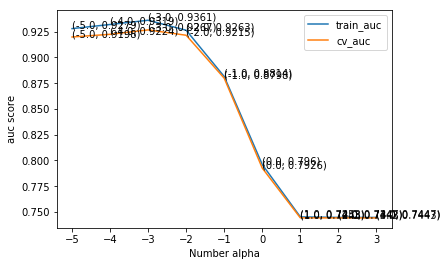

For values of best alpha =  0.001 The train auc is: 97.13248216239703
For values of best alpha =  0.001 The cross validation auc is: 93.72567170869293
For values of best alpha =  0.001 The test  auc is: 93.66839216038424


In [122]:
# Please write all the code with proper documentation
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)

    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(bag_counts,  y_tr)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(bag_counts, y_tr)
    scores_train = cross_val_score(sig_clf, bag_counts, y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, cvvalues, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())

# determining best alpha
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()



best_alpha = optimal_alpha
clf=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)### training the model with the best alpha value
clf.fit(bag_counts, y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(bag_counts, y_tr)


predict_y = sig_clf.predict_proba(bag_counts)[:,1]
acc = roc_auc_score(y_tr, predict_y)*100
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha value
predict_y = sig_clf.predict_proba(cvvalues)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha value
predict_y = sig_clf.predict_proba(testvalues)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha value

# ROC curve for train and test data of linear svm bow

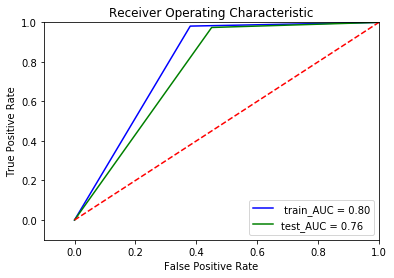

In [123]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
best_alpha = optimal_alpha
clf=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)### training the model with the best alpha value
clf.fit(bag_counts, y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(bag_counts, y_tr)


predict_y_train = sig_clf.predict(bag_counts)
predict_y_test = sig_clf.predict(testvalues)
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# construction of confusion matrix for test data

-------------------- Confusion matrix --------------------


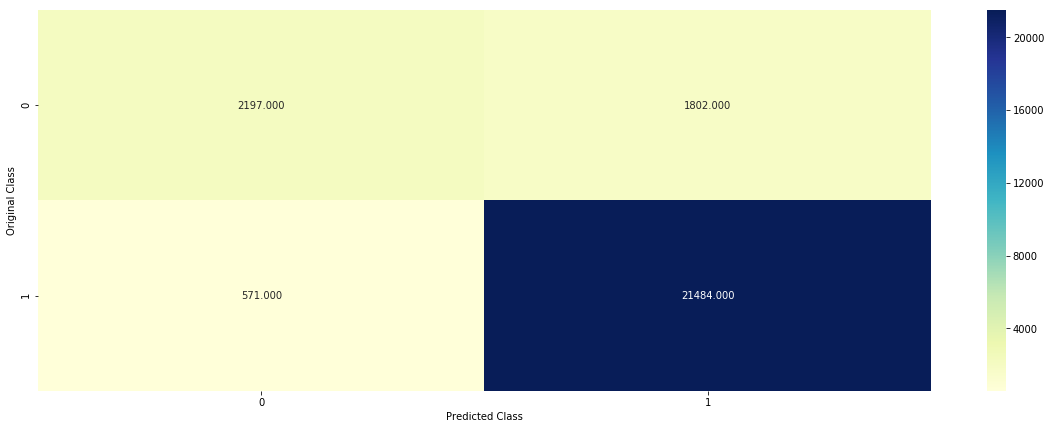

-------------------- Precision matrix (Columm Sum=1) --------------------


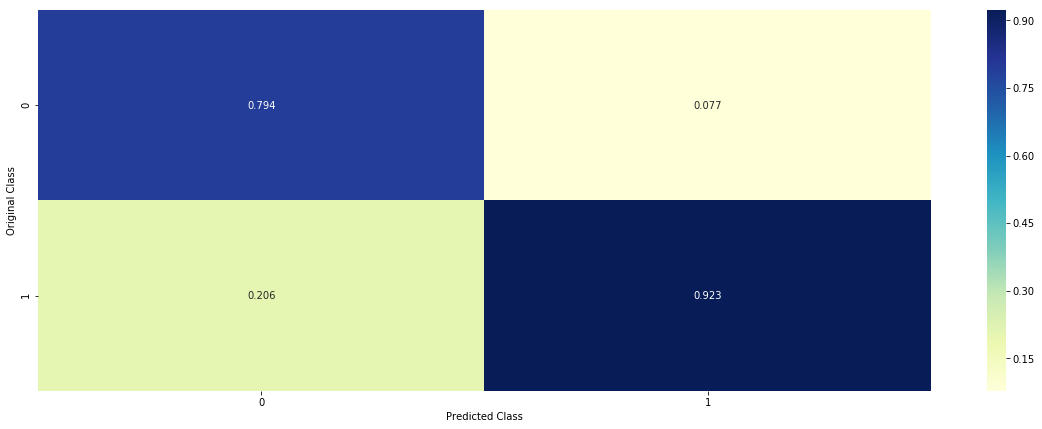

-------------------- Recall matrix (Row sum=1) --------------------


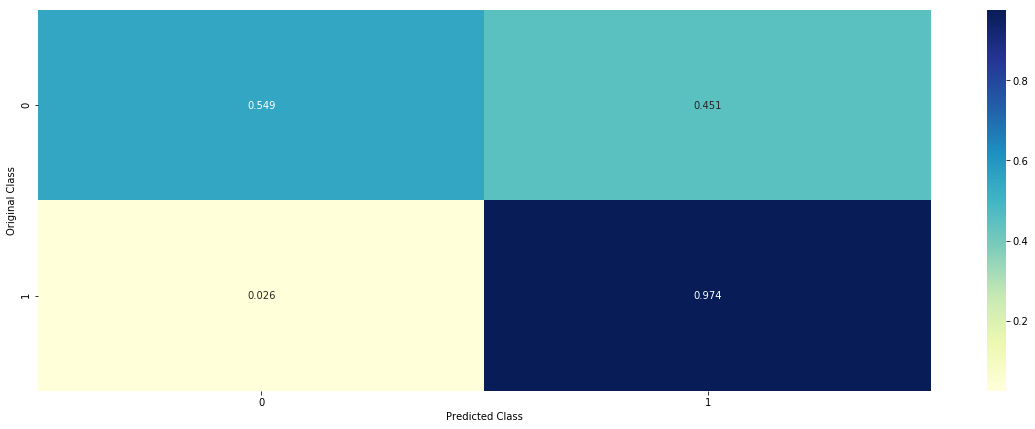

In [98]:
predict_y = sig_clf.predict(testvalues)
plot_confusion_matrix(y_test, predict_y)

# confusion matrix for train data

-------------------- Confusion matrix --------------------


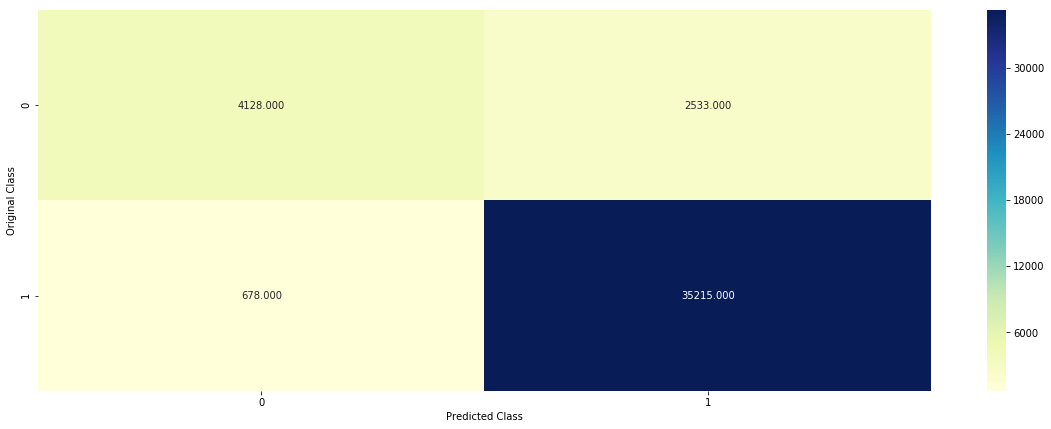

-------------------- Precision matrix (Columm Sum=1) --------------------


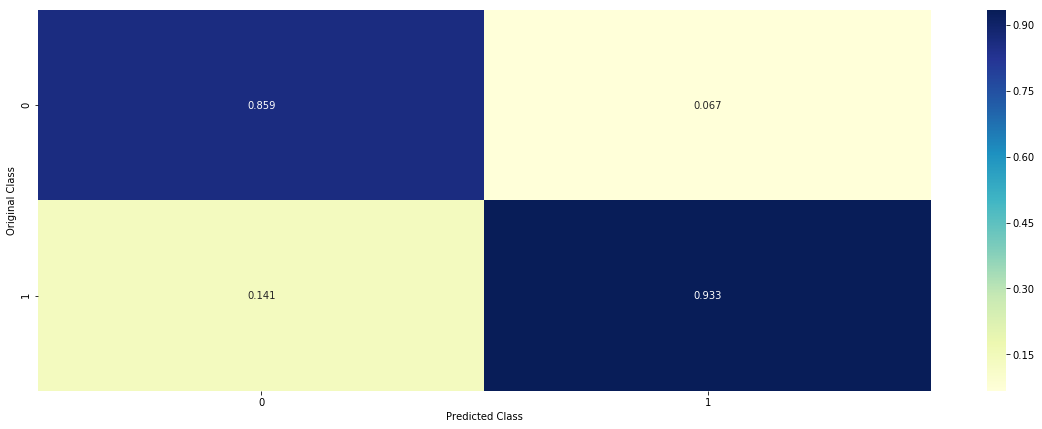

-------------------- Recall matrix (Row sum=1) --------------------


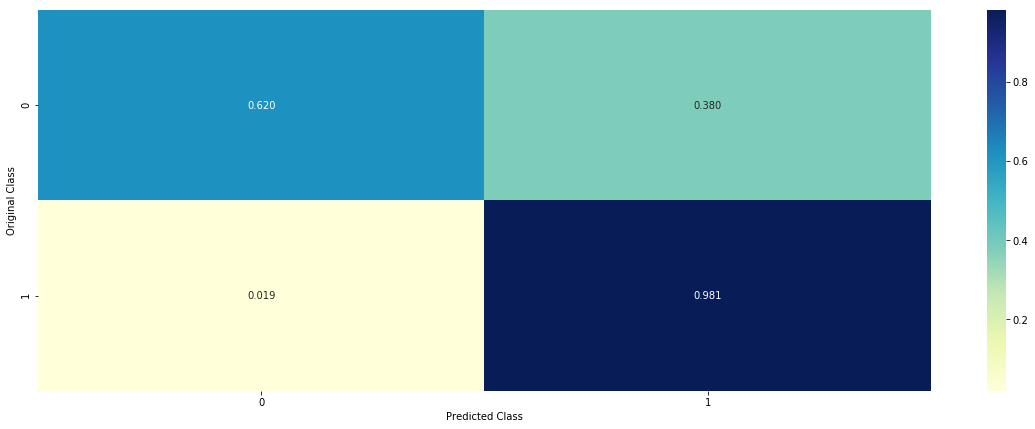

In [99]:
predict_y = sig_clf.predict(bag_counts)
plot_confusion_matrix(y_tr, predict_y)

# Important features for positive and negative classes for BOW

In [124]:
coef = clf.coef_.ravel()
features=count_vect.get_feature_names()
topn_features0 = sorted(zip(coef, features),reverse=True)[:20]
topn_features1 = sorted(zip(coef, features))[:20]
print('***** positive features********')
for coef,features in topn_features0:
    print("feature: %s" %(features))
print(topn_features0)
print('***** neagative features********')
for coef,features in topn_features1:
    print(" feature: %s" %(features))
print(topn_features1)

***** positive features********
feature: delicious
feature: perfect
feature: excellent
feature: great
feature: best
feature: loves
feature: fantastic
feature: wonderful
feature: pleased
feature: amazing
feature: smooth
feature: highly
feature: awesome
feature: beat
feature: yummy
feature: love
feature: pleasantly
feature: favorite
feature: happy
feature: exactly
[(0.9340473947649099, 'delicious'), (0.8782826414015208, 'perfect'), (0.7940080089981677, 'excellent'), (0.7890419014235455, 'great'), (0.7865331457414576, 'best'), (0.77046298378184, 'loves'), (0.7609202672659414, 'fantastic'), (0.7415778152861886, 'wonderful'), (0.7113277299060261, 'pleased'), (0.6989695066384488, 'amazing'), (0.6825863248544219, 'smooth'), (0.6741293566746981, 'highly'), (0.6471419492239228, 'awesome'), (0.6398183719170671, 'beat'), (0.6004209194921359, 'yummy'), (0.5995516521560131, 'love'), (0.5896929903967852, 'pleasantly'), (0.5843432350267215, 'favorite'), (0.567054009211576, 'happy'), (0.54868321423013

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.9423 0.9471 0.9308 0.8988 0.8982 0.8982 0.8982 0.8982 0.8982]
the auc score for cv data for each alpha value is :  [0.9316 0.9399 0.9311 0.9012 0.9009 0.9009 0.9009 0.9009 0.9009]

The optimal alpha is. 0.0001


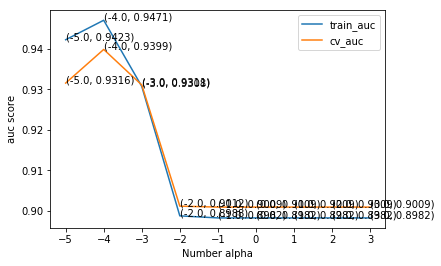

For values of best alpha =  0.0001 The train auc is: 0.974476652325234
For values of best alpha =  0.0001 The cross validation auc is: 94.86056742815978
For values of best alpha =  0.0001 The test  auc is: 94.82219908865224


In [100]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
#     
    clf_tfidf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf_tfidf.fit(bag_counts,  y_tr)
    sig_clf = CalibratedClassifierCV(clf_tfidf, method="sigmoid")
    sig_clf.fit(train_tfidf_text, y_tr)
    scores_train = cross_val_score(sig_clf, train_tfidf_text, y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, cv_tfidf_text, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())

# determining best alpha
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()



best_alpha = optimal_alpha
clf_tfidf=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf_tfidf.fit(train_tfidf_text, y_tr)
sig_clf = CalibratedClassifierCV(clf_tfidf, method="sigmoid")
sig_clf.fit(train_tfidf_text, y_tr)


predict_y = sig_clf.predict_proba(train_tfidf_text)[:,1]
acc = roc_auc_score(y_tr, predict_y)
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha value
predict_y = sig_clf.predict_proba(cv_tfidf_text)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha value
predict_y = sig_clf.predict_proba(test_tfidf_text)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha value

# construction of confusion matrix 

-------------------- Confusion matrix --------------------


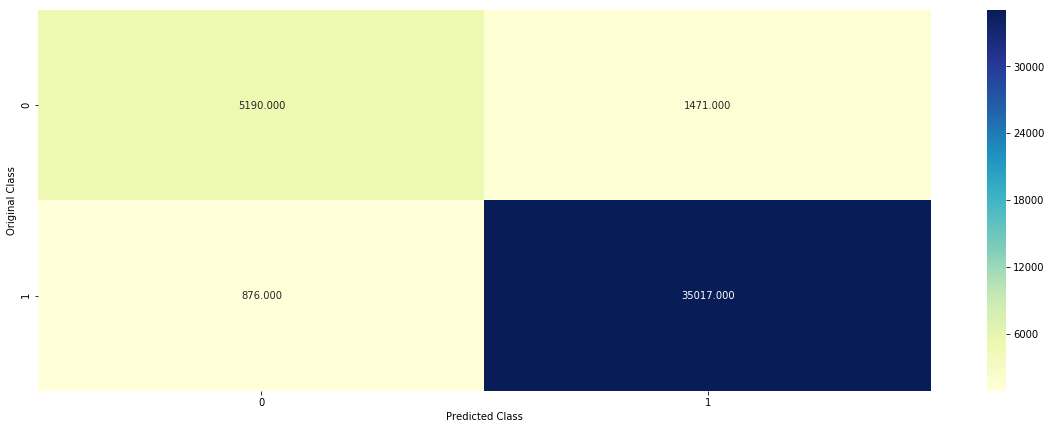

-------------------- Precision matrix (Columm Sum=1) --------------------


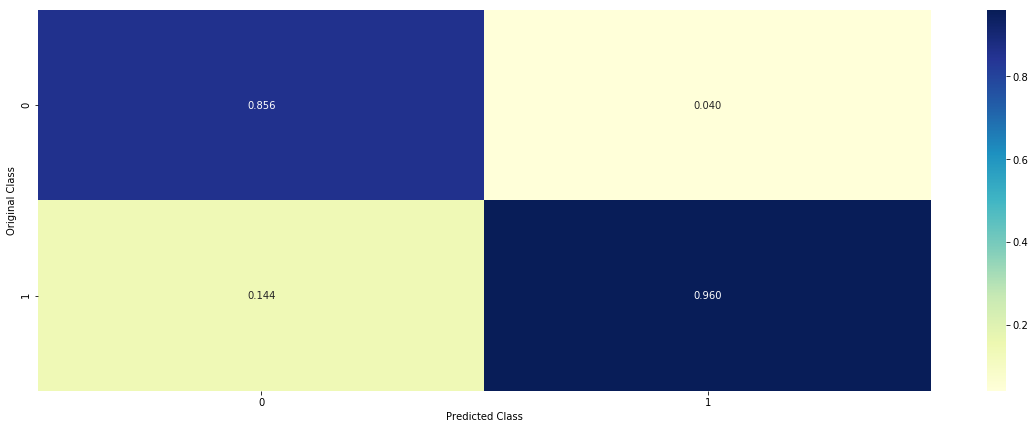

-------------------- Recall matrix (Row sum=1) --------------------


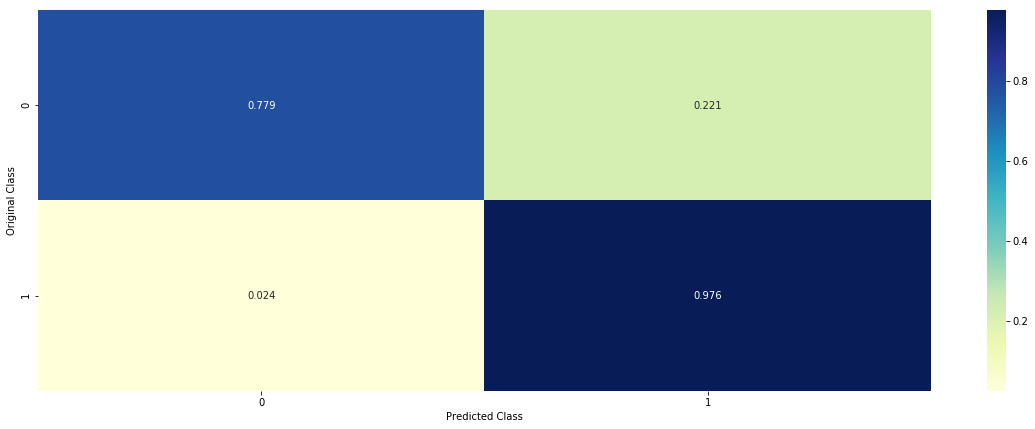

In [101]:
predict_y = sig_clf.predict(train_tfidf_text)
plot_confusion_matrix(y_tr, predict_y)

# Confusion matrix for test data

-------------------- Confusion matrix --------------------


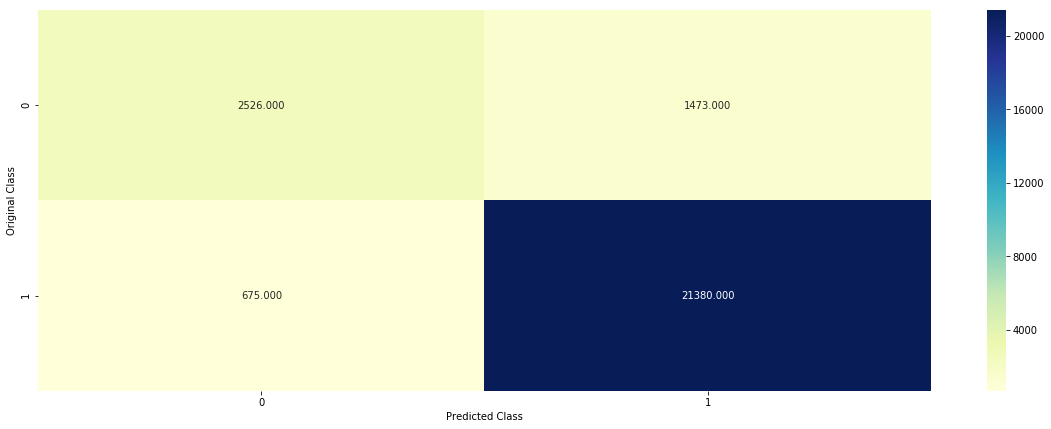

-------------------- Precision matrix (Columm Sum=1) --------------------


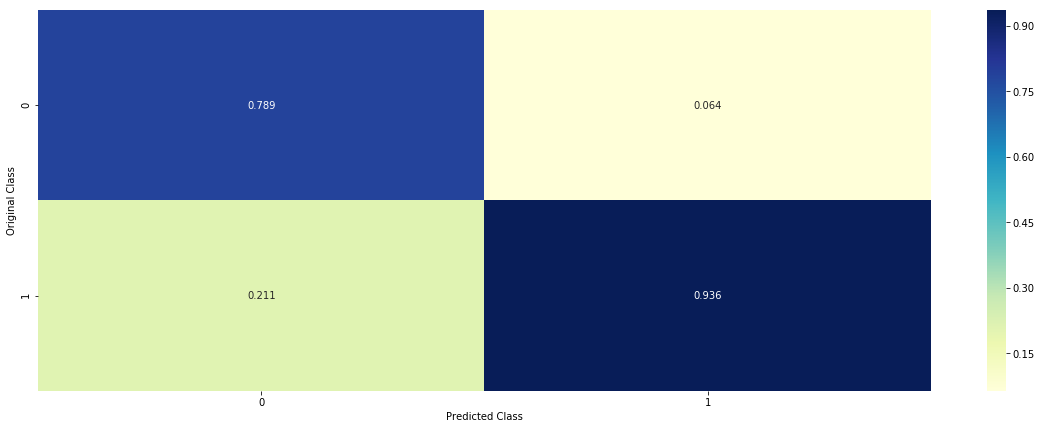

-------------------- Recall matrix (Row sum=1) --------------------


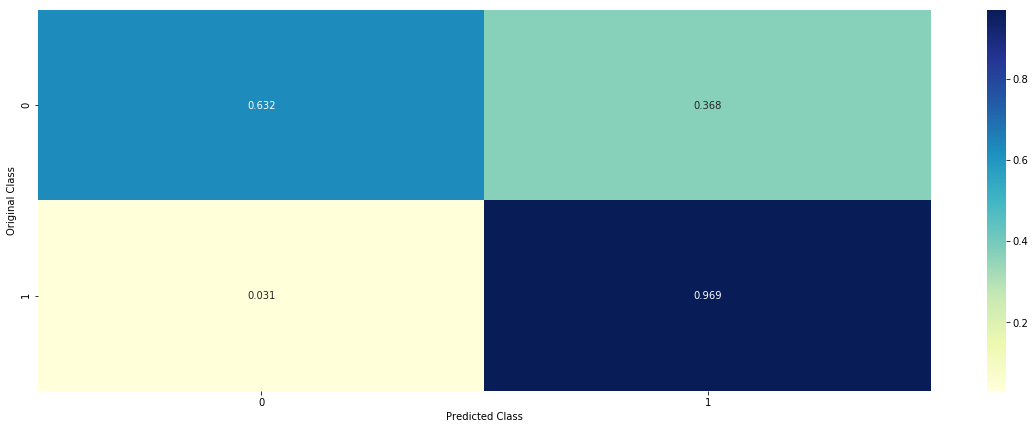

In [102]:
predict_y = sig_clf.predict(test_tfidf_text)
plot_confusion_matrix(y_test, predict_y)

# # ROC curve for train and test data of linear svm tfidf

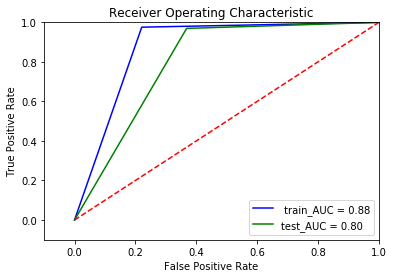

In [103]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
best_alpha = optimal_alpha
clf=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)### training the model with the best alpha value
clf.fit(train_tfidf_text, y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_tfidf_text, y_tr)


predict_y_train = sig_clf.predict(train_tfidf_text)
predict_y_test = sig_clf.predict(test_tfidf_text)
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# Important features for positive and negative classes for TFIDF

In [115]:
coef = clf_tfidf.coef_.ravel()
features=tf_idf_vect.get_feature_names()
topn_features0 = sorted(zip(coef, features),reverse=True)[:20]
topn_features1 = sorted(zip(coef, features))[:20]
print('***** positive features********')
for coef,features in topn_features0:
    print("value : %d   feature: %s" %(coef,features))
print(topn_features0)
print('***** neagative features********')
for coef,features in topn_features1:
    print("value : %d   feature: %s" %(coef,features))
print(topn_features1)


***** positive features********
value : 6   feature: great
value : 5   feature: best
value : 4   feature: delicious
value : 4   feature: love
value : 3   feature: loves
value : 3   feature: perfect
value : 3   feature: good
value : 3   feature: excellent
value : 3   feature: wonderful
value : 3   feature: nice
value : 3   feature: highly
value : 2   feature: amazing
value : 2   feature: pleased
value : 2   feature: happy
value : 2   feature: favorite
value : 2   feature: smooth
value : 2   feature: easy
value : 2   feature: tasty
value : 2   feature: awesome
value : 2   feature: definitely
[(6.4764951167983895, 'great'), (5.2012041311445065, 'best'), (4.776216352119944, 'delicious'), (4.223782600031428, 'love'), (3.999772480467029, 'loves'), (3.9551423255820737, 'perfect'), (3.6211199877165376, 'good'), (3.468126837855985, 'excellent'), (3.322169332583928, 'wonderful'), (3.105774267853704, 'nice'), (3.0421822760650716, 'highly'), (2.971745405007691, 'amazing'), (2.74558343572945, 'plea

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.8869 0.8923 0.8974 0.8969 0.8919 0.8761 0.8465 0.8763 0.8761]
the auc score for cv data for each alpha value is :  [0.8745 0.8816 0.8945 0.895  0.8896 0.8707 0.868  0.8705 0.8704]

The optimal alpha is. 0.001


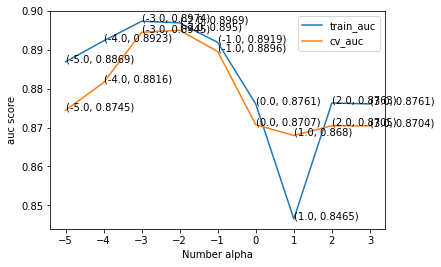

For values of best alpha =  0.001 The train auc is: 0.8989172090679886
For values of best alpha =  0.001 The cross validation auc is: 89.7096836884608
For values of best alpha =  0.001 The test  auc is: 89.71420252478673


In [104]:
# Please write all the code with proper documentation
## word 2 vec for linear
# Please write all the code with proper documentation
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000]  ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
#    
    clf_word = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf_word.fit(sent_vectors,  y_tr)
    sig_clf = CalibratedClassifierCV(clf_word, method="sigmoid")
    sig_clf.fit(sent_vectors, y_tr)
    scores_train = cross_val_score(sig_clf, sent_vectors, y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, sent_vectors_cv, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())

# determining best alpha
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()



best_alpha = optimal_alpha
clf_word=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf_word.fit(sent_vectors, y_tr)
sig_clf = CalibratedClassifierCV(clf_word, method="sigmoid")
sig_clf.fit(sent_vectors, y_tr)


predict_y = sig_clf.predict_proba(sent_vectors)[:,1]
acc = roc_auc_score(y_tr, predict_y)
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha value
predict_y = sig_clf.predict_proba(sent_vectors_cv)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha value
predict_y = sig_clf.predict_proba(sent_vectors_test)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha value

# ROC curve for train and test data of linear svm word2vec

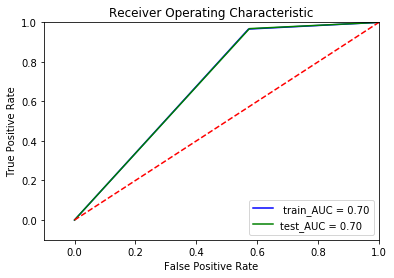

In [105]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
best_alpha = optimal_alpha
clf_word=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf_word.fit(sent_vectors, y_tr)
sig_clf = CalibratedClassifierCV(clf_word, method="sigmoid")
sig_clf.fit(sent_vectors, y_tr)


predict_y_train =  sig_clf.predict(sent_vectors)
predict_y_test =sig_clf.predict(sent_vectors_test)
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# construction of confusion matrix for test data

-------------------- Confusion matrix --------------------


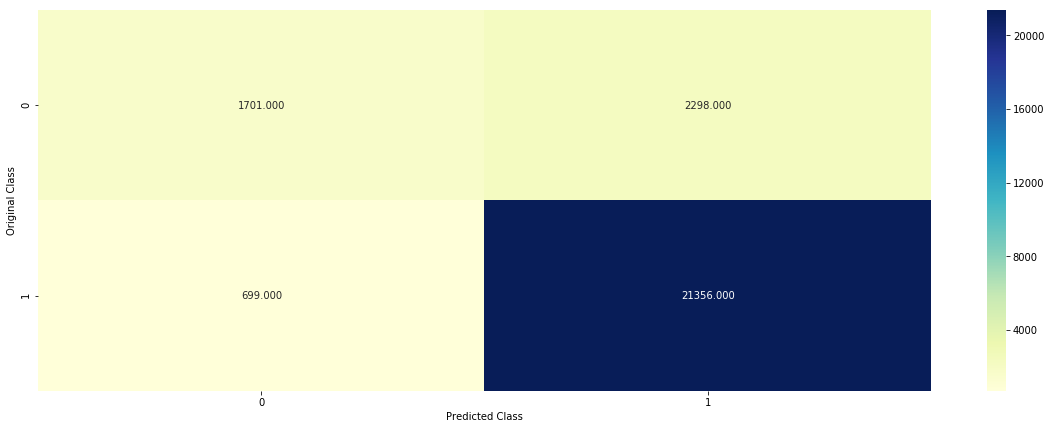

-------------------- Precision matrix (Columm Sum=1) --------------------


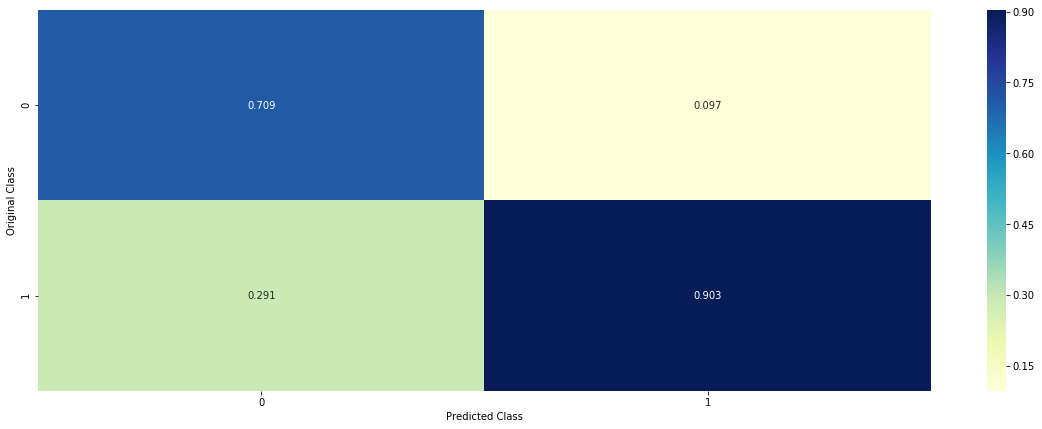

-------------------- Recall matrix (Row sum=1) --------------------


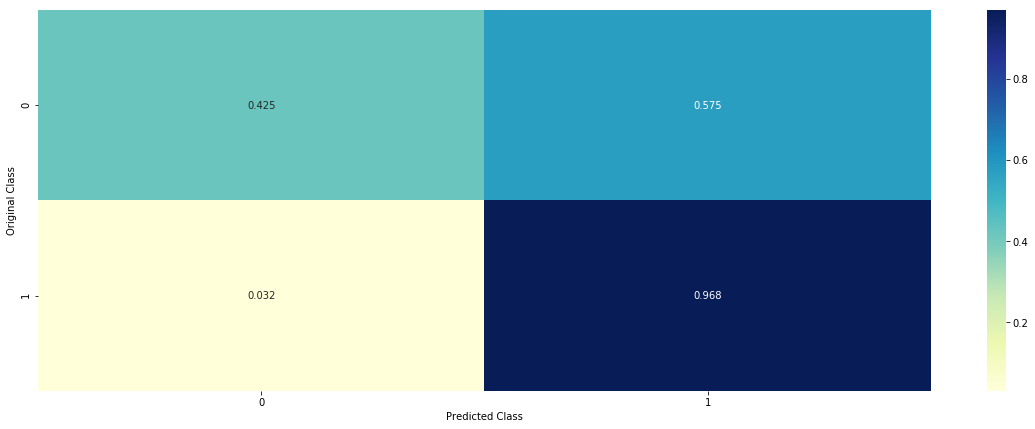

In [106]:

predict_y = sig_clf.predict(sent_vectors_test)
plot_confusion_matrix(y_test, predict_y)

# # Confusion matrix for train data

-------------------- Confusion matrix --------------------


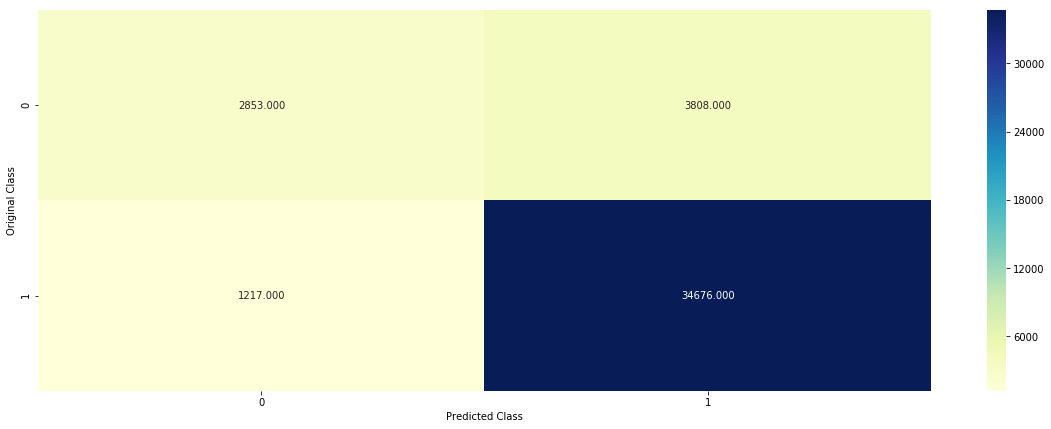

-------------------- Precision matrix (Columm Sum=1) --------------------


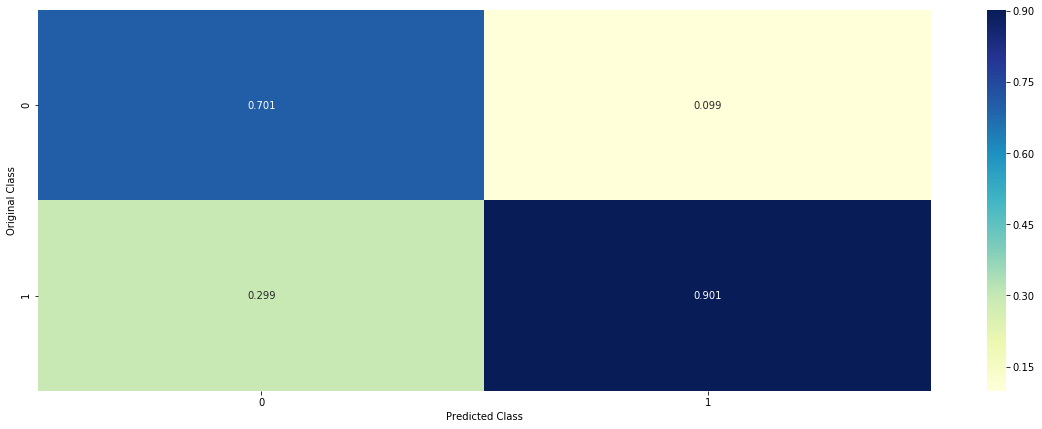

-------------------- Recall matrix (Row sum=1) --------------------


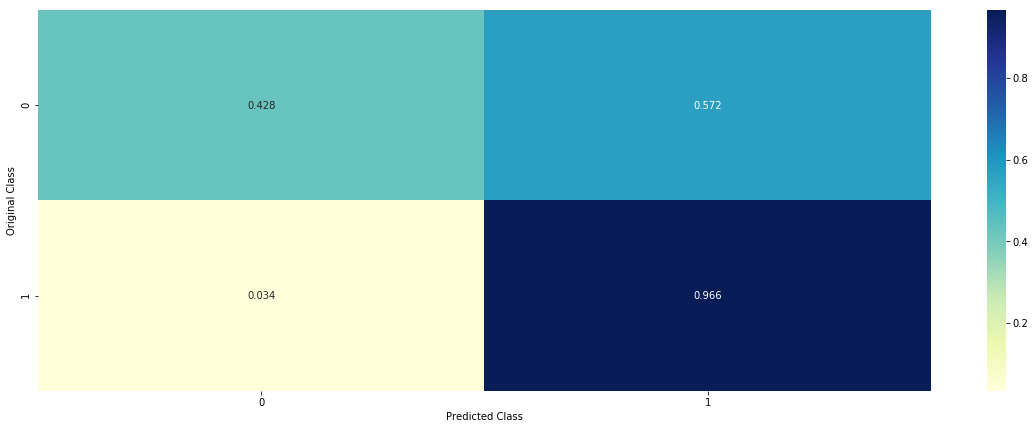

In [107]:

predict_y = sig_clf.predict(sent_vectors)
plot_confusion_matrix(y_tr, predict_y)

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.848  0.8603 0.8724 0.872  0.8652 0.8458 0.8136 0.8439 0.843 ]
the auc score for cv data for each alpha value is :  [0.8381 0.8433 0.8656 0.8699 0.8624 0.8335 0.8296 0.833  0.8328]

The optimal alpha is. 0.001


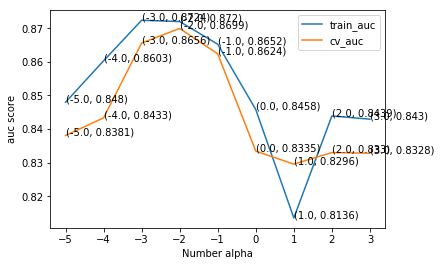

For values of best alpha =  0.001 The train auc is: 0.8735814341139625
For values of best alpha =  0.001 The cross validation auc is: 87.11901215477673
For values of best alpha =  0.001 The test  auc is: 86.85833666532707


In [108]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation tfidf w2 vec for linear
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf_word_tfidf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf_word_tfidf.fit(tfidf_sent_vectors,  y_tr)
    sig_clf = CalibratedClassifierCV(clf_word_tfidf, method="sigmoid")
    sig_clf.fit(tfidf_sent_vectors, y_tr)
    scores_train = cross_val_score(sig_clf, tfidf_sent_vectors, y_tr, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, tfidf_sent_vectors_cv, y_cv, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())

# determining best alpha
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()



best_alpha = optimal_alpha
clf_word_tfidf=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf_word_tfidf.fit(tfidf_sent_vectors, y_tr)
sig_clf = CalibratedClassifierCV(clf_word_tfidf, method="sigmoid")
sig_clf.fit(tfidf_sent_vectors, y_tr)


predict_y = sig_clf.predict_proba(tfidf_sent_vectors)[:,1]
acc = roc_auc_score(y_tr, predict_y)
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha valu
predict_y = sig_clf.predict_proba(tfidf_sent_vectors_cv)[:,1]
acc = roc_auc_score( y_cv, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc)### auc score for cv data using best alpha valu
predict_y = sig_clf.predict_proba(tfidf_sent_vectors_test)[:,1]
acc = roc_auc_score( y_test, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha valu

# ROC curve for train and test data of linear svm tfidf word2vec

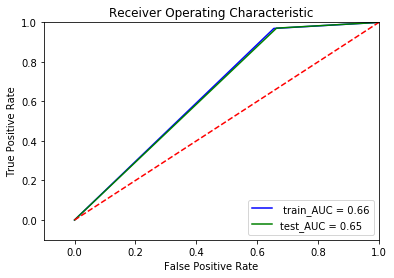

In [109]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

best_alpha = optimal_alpha
clf_word_tfidf=SGDClassifier( class_weight='balanced', alpha=best_alpha, penalty='l2', loss='hinge', random_state=42)
clf_word_tfidf.fit(tfidf_sent_vectors, y_tr)
sig_clf = CalibratedClassifierCV(clf_word_tfidf, method="sigmoid")
sig_clf.fit(tfidf_sent_vectors, y_tr)


predict_y_train =  sig_clf.predict(tfidf_sent_vectors)
predict_y_test =sig_clf.predict(tfidf_sent_vectors_test)
y1= np.array(y_tr)
y2=np.array(y_test)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# construction of confusion matrix for test data

-------------------- Confusion matrix --------------------


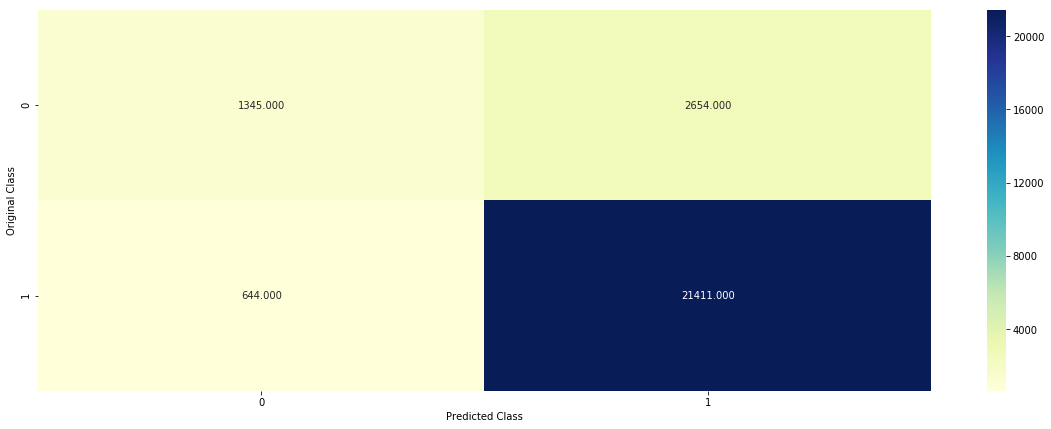

-------------------- Precision matrix (Columm Sum=1) --------------------


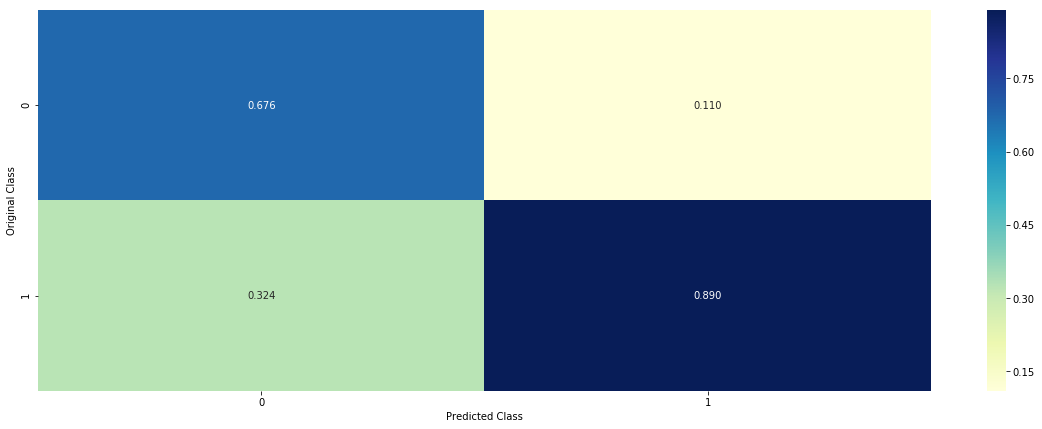

-------------------- Recall matrix (Row sum=1) --------------------


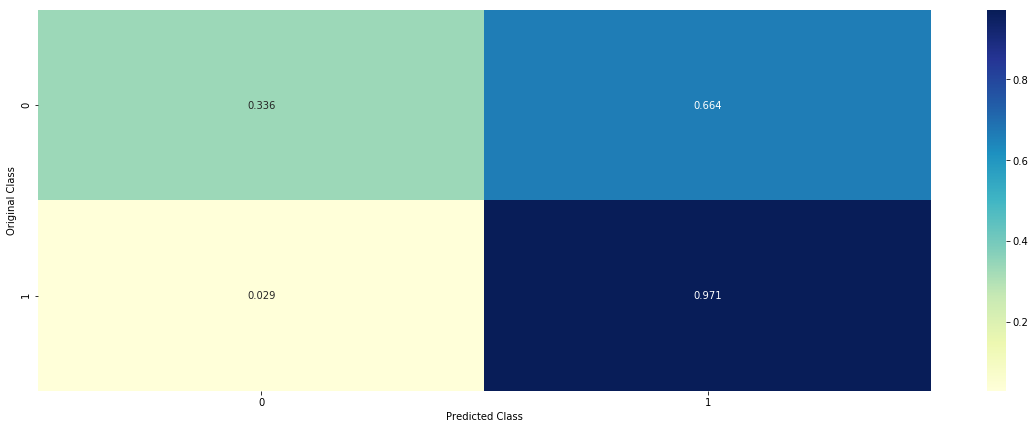

In [110]:


predict_y = sig_clf.predict(tfidf_sent_vectors_test)
plot_confusion_matrix(y_test, predict_y)

# # Confusion matrix for train data

-------------------- Confusion matrix --------------------


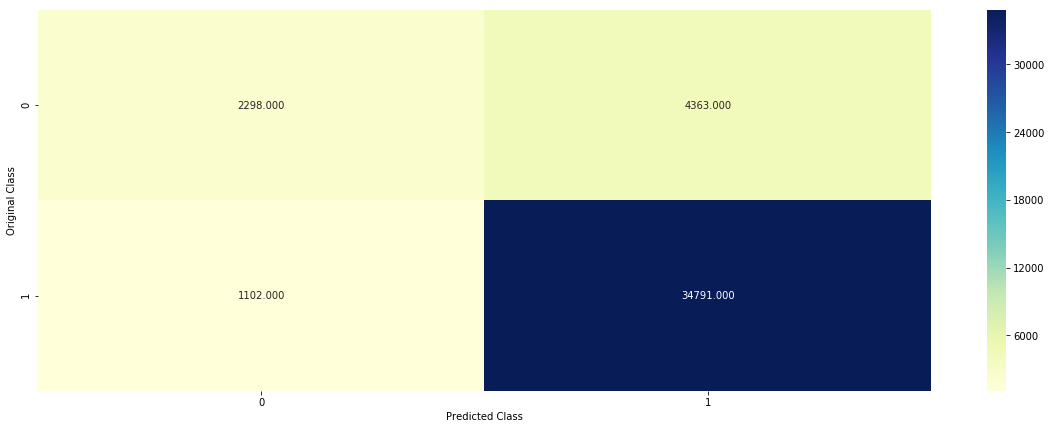

-------------------- Precision matrix (Columm Sum=1) --------------------


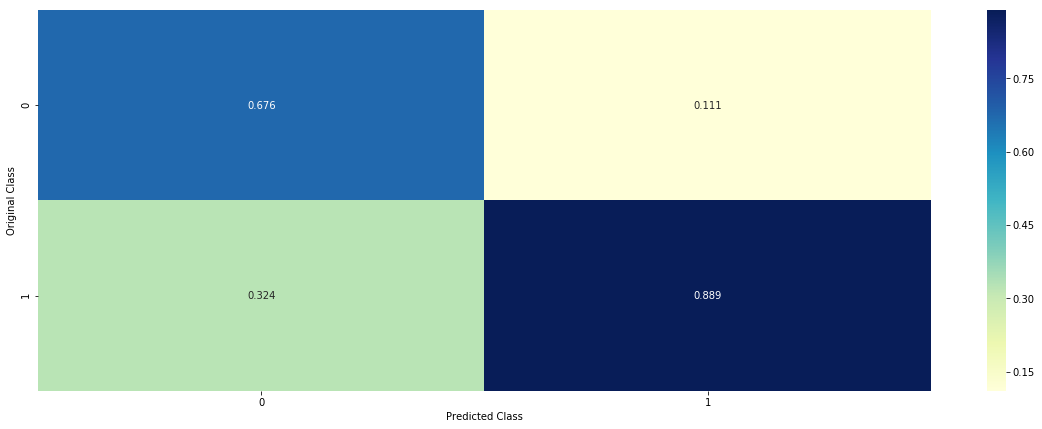

-------------------- Recall matrix (Row sum=1) --------------------


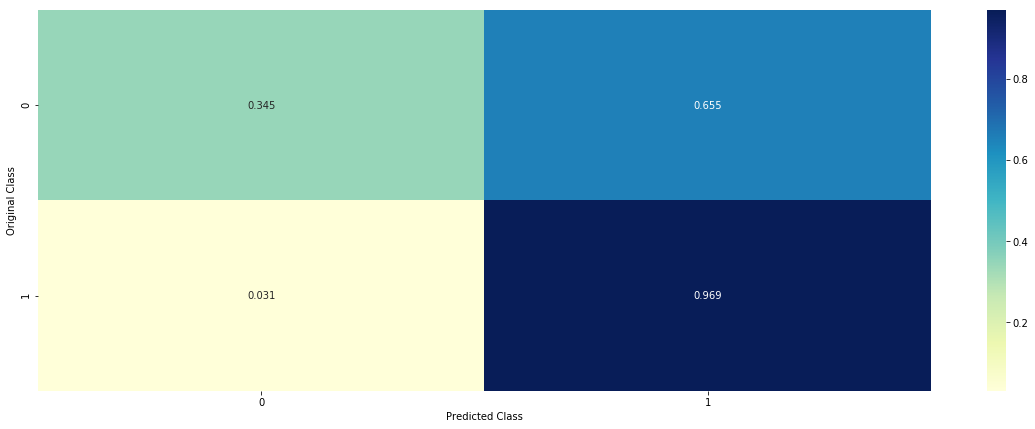

In [111]:


predict_y = sig_clf.predict(tfidf_sent_vectors)
plot_confusion_matrix(y_tr, predict_y)

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.6491 0.7011 0.8296 0.8789 0.8808 0.8809 0.8881 0.8851 0.8719]
the auc score for cv data for each alpha value is :  [0.6298 0.6512 0.7687 0.8372 0.8415 0.8419 0.8482 0.8418 0.825 ]

The optimal alpha is. 10


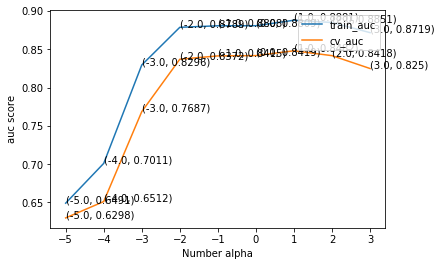

For values of best alpha =  10 The train auc is: 0.9325134491299101
For values of best alpha =  10 The cross validation auc is: 87.84077907712094
For values of best alpha =  10 The test  auc is: 89.20477212543554


In [68]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
#svc for bow
from sklearn.svm import SVC
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
    clf_bag= SVC(C=i)
    clf_bag.fit(bag_counts2, y_tr2)
    sig_clf = CalibratedClassifierCV(clf_bag, method="sigmoid")
    sig_clf.fit(bag_counts2, y_tr2)
    scores_train = cross_val_score(sig_clf, bag_counts2, y_tr2, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, cvvalues2, y_cv2, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()

best_alpha = optimal_alpha
clf_bag= SVC(C=best_alpha)
clf_bag.fit(bag_counts2, y_tr2)
sig_clf = CalibratedClassifierCV(clf_bag, method="sigmoid")
sig_clf.fit(bag_counts2, y_tr2)

predict_y = sig_clf.predict_proba(bag_counts2)[:,1]
acc = roc_auc_score(y_tr2, predict_y)
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha valu
predict_y = sig_clf.predict_proba(cvvalues2)[:,1]
acc = roc_auc_score( y_cv2, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha valu
predict_y = sig_clf.predict_proba(testvalues2)[:,1]
acc = roc_auc_score( y_test2, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha valu
    


# ROC curve for train and test data of RBF kernal svm bow

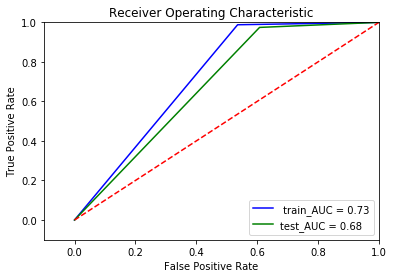

In [69]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

best_alpha = optimal_alpha
clf_bag= SVC(C=best_alpha)
clf_bag.fit(bag_counts2, y_tr2)
sig_clf = CalibratedClassifierCV(clf_bag, method="sigmoid")
sig_clf.fit(bag_counts2, y_tr2)

predict_y_train =  sig_clf.predict(bag_counts2)
predict_y_test =sig_clf.predict(testvalues2)
y1= np.array(y_tr2)
y2=np.array(y_test2)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# construction of confusion matrix

-------------------- Confusion matrix --------------------


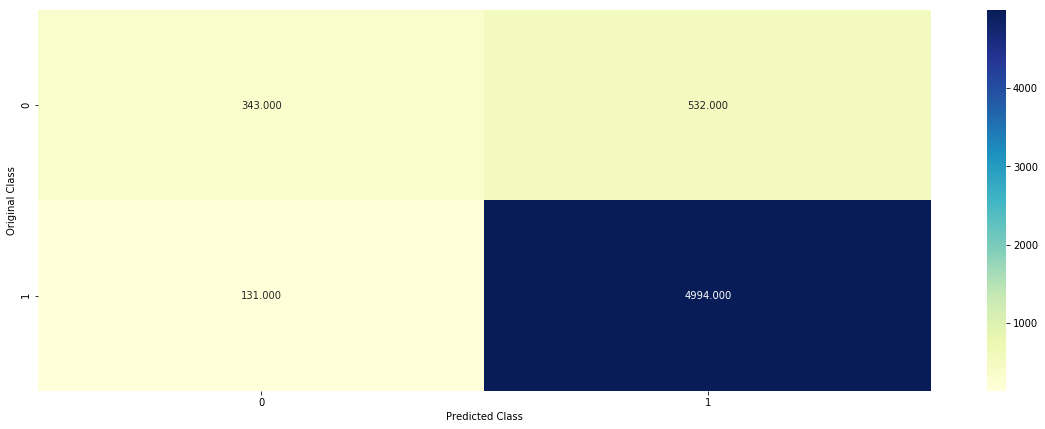

-------------------- Precision matrix (Columm Sum=1) --------------------


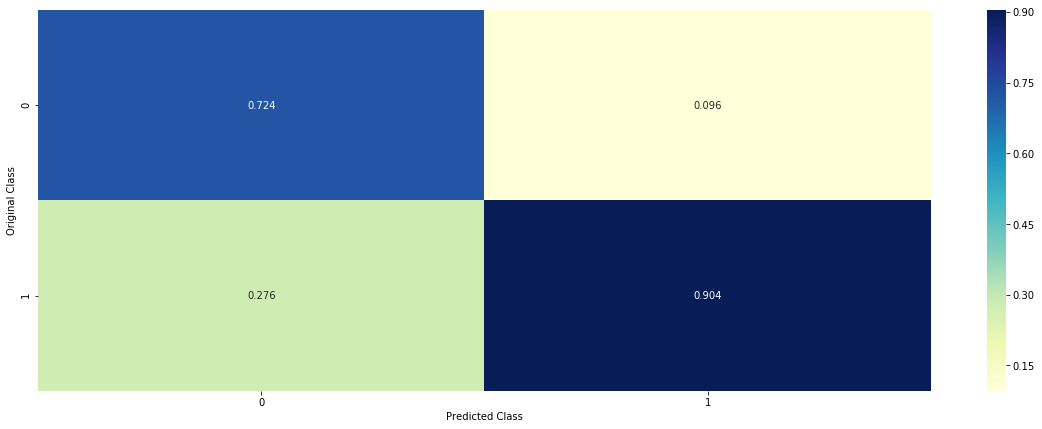

-------------------- Recall matrix (Row sum=1) --------------------


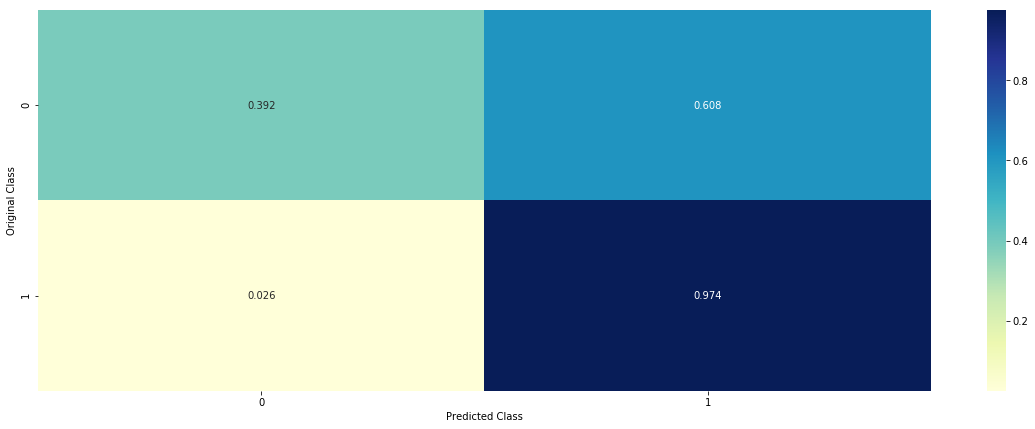

In [70]:
predict_y = sig_clf.predict(testvalues2)
plot_confusion_matrix(y_test2, predict_y)

# Confusion matrix for train data

-------------------- Confusion matrix --------------------


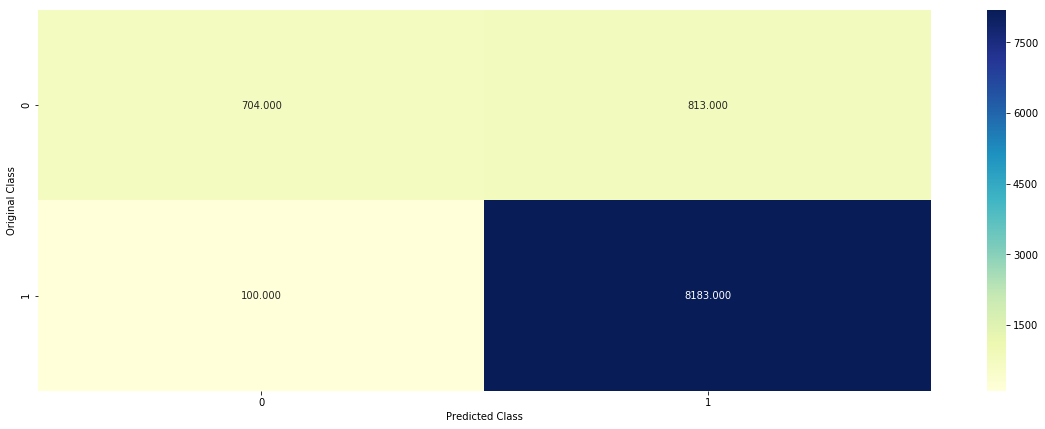

-------------------- Precision matrix (Columm Sum=1) --------------------


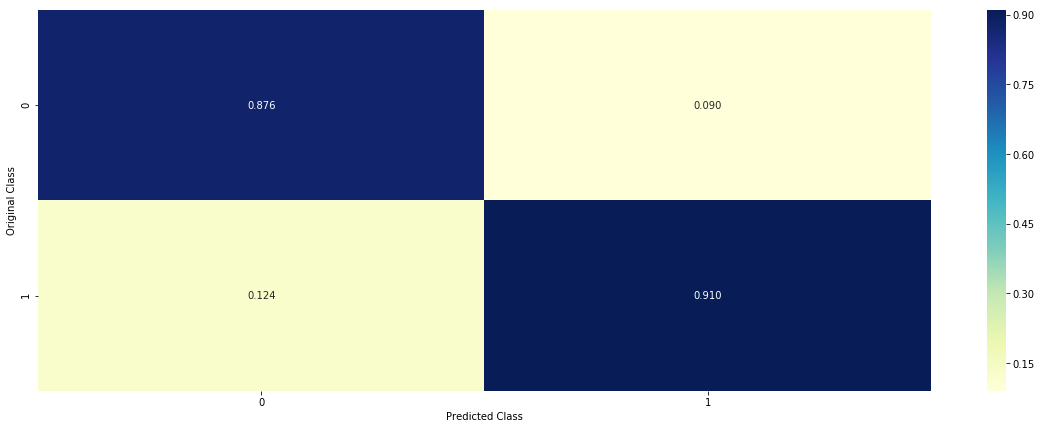

-------------------- Recall matrix (Row sum=1) --------------------


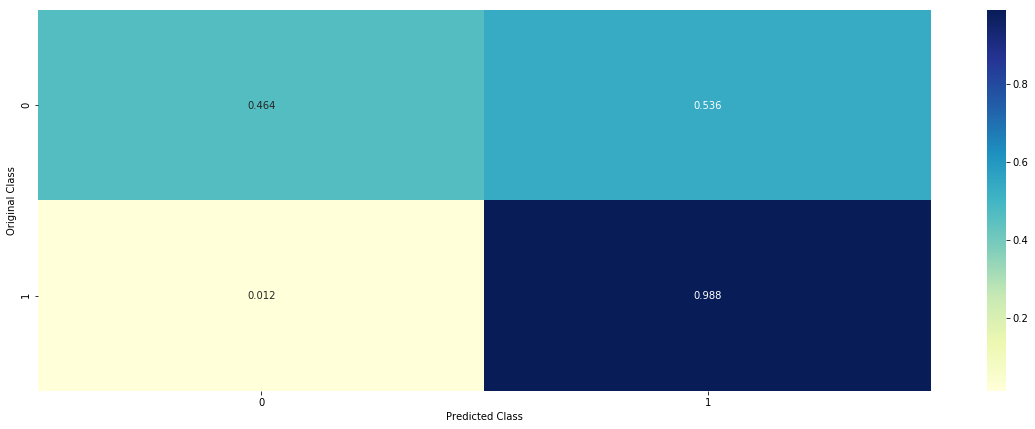

In [71]:
predict_y = sig_clf.predict(bag_counts2)
plot_confusion_matrix(y_tr2, predict_y)

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.8823 0.8791 0.8781 0.8807 0.8825 0.8995 0.9296 0.9301 0.9301]
the auc score for cv data for each alpha value is :  [0.865  0.865  0.8605 0.8606 0.8655 0.8657 0.8982 0.8995 0.8993]

The optimal alpha is. 100


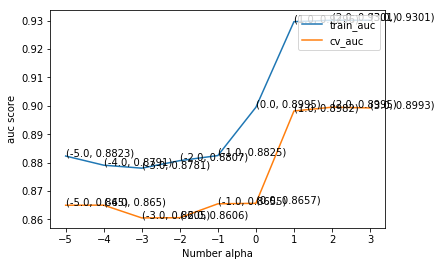

For values of best alpha =  100 The train auc is: 0.9809273721915837
For values of best alpha =  100 The cross validation auc is: 92.28918508966406
For values of best alpha =  100 The test  auc is: 92.94396655052265


In [74]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
## tfidf code for svc
from sklearn.svm import SVC
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
    clf_tfidf= SVC(C=i)
    clf_tfidf.fit(train_tfidf_text2, y_tr2)
    sig_clf = CalibratedClassifierCV(clf_tfidf, method="sigmoid")
    sig_clf.fit(train_tfidf_text2, y_tr2)
    scores_train = cross_val_score(sig_clf, train_tfidf_text2, y_tr2, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, cv_tfidf_text2, y_cv2, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()

best_alpha = optimal_alpha
clf_tfidf= SVC(C=best_alpha)
clf_tfidf.fit(train_tfidf_text2, y_tr2)
sig_clf = CalibratedClassifierCV(clf_tfidf, method="sigmoid")
sig_clf.fit(train_tfidf_text2, y_tr2)

predict_y = sig_clf.predict_proba(train_tfidf_text2)[:,1]
acc = roc_auc_score(y_tr2, predict_y)
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha valu
predict_y = sig_clf.predict_proba(cv_tfidf_text2)[:,1]
acc = roc_auc_score( y_cv2, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha valu
predict_y = sig_clf.predict_proba(test_tfidf_text2)[:,1]
acc = roc_auc_score( y_test2, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha valu


# construction of confusion matrix for test data

-------------------- Confusion matrix --------------------


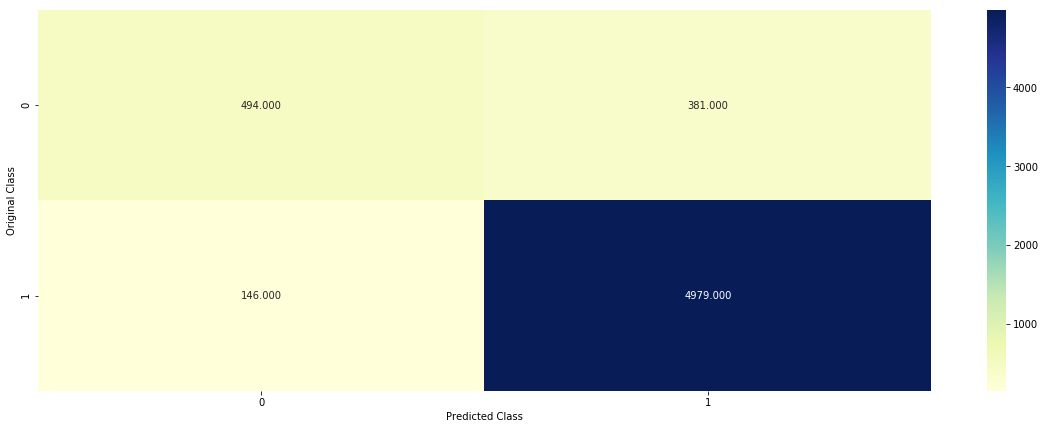

-------------------- Precision matrix (Columm Sum=1) --------------------


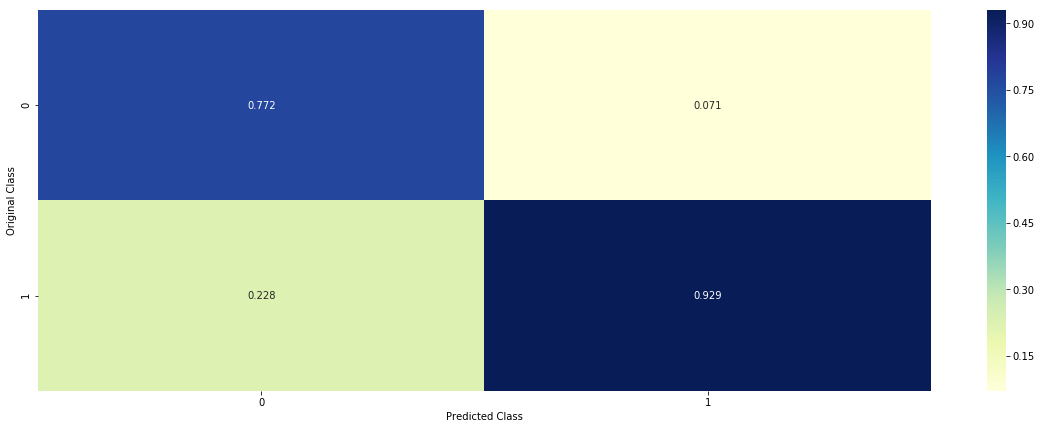

-------------------- Recall matrix (Row sum=1) --------------------


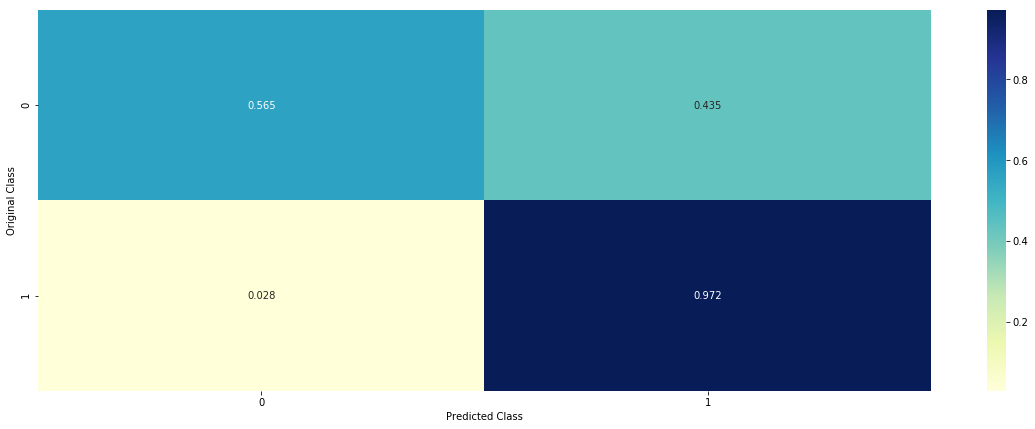

In [75]:
predict_y = sig_clf.predict(test_tfidf_text2)
plot_confusion_matrix(y_test2, predict_y)

# Confusion matrix for train data

-------------------- Confusion matrix --------------------


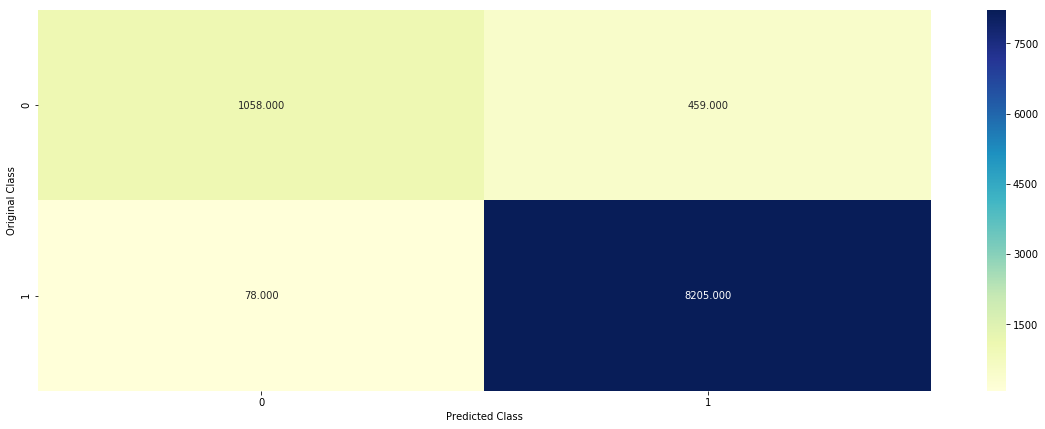

-------------------- Precision matrix (Columm Sum=1) --------------------


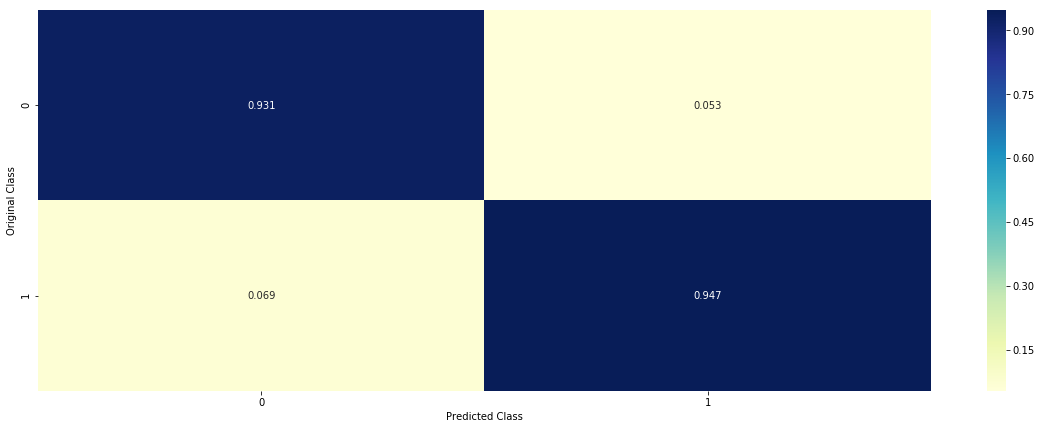

-------------------- Recall matrix (Row sum=1) --------------------


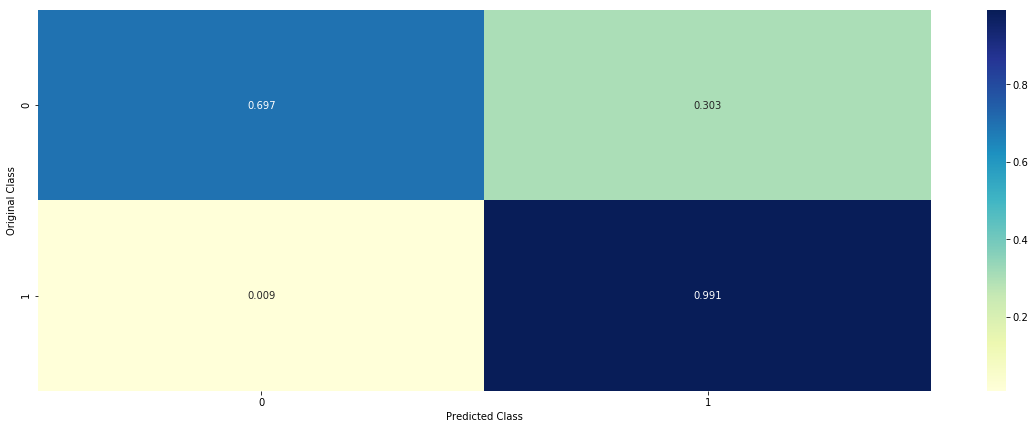

In [76]:
predict_y = sig_clf.predict(train_tfidf_text2)
plot_confusion_matrix(y_tr2, predict_y)

# ROC curve for train and test data of RBF Kernal svm TFIDF

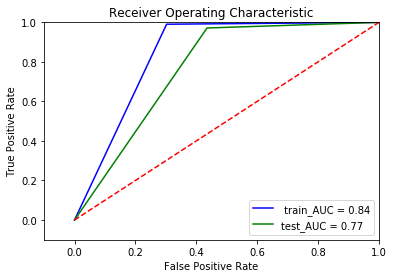

In [77]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

best_alpha = optimal_alpha
clf_bag= SVC(C=best_alpha)
clf_bag.fit(train_tfidf_text2, y_tr2)
sig_clf = CalibratedClassifierCV(clf_bag, method="sigmoid")
sig_clf.fit(train_tfidf_text2, y_tr2)

predict_y_train =  sig_clf.predict(train_tfidf_text2)
predict_y_test =sig_clf.predict(test_tfidf_text2)
y1= np.array(y_tr2)
y2=np.array(y_test2)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.7116 0.7158 0.7633 0.8029 0.8304 0.8506 0.8535 0.8538 0.8572]
the auc score for cv data for each alpha value is :  [0.7153 0.7243 0.7481 0.784  0.8207 0.8432 0.846  0.8464 0.8487]

The optimal alpha is. 1000


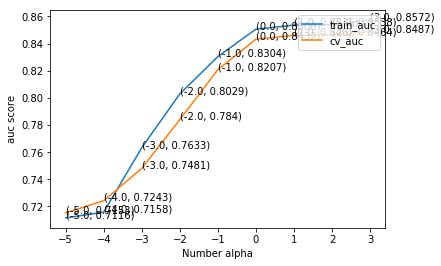

For values of best alpha =  1000 The train auc is: 0.8724561612521966
For values of best alpha =  1000 The cross validation auc is: 85.51017022802682
For values of best alpha =  1000 The test  auc is: 86.40093658536586


In [86]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
## word 2 vec code for svc
from sklearn.svm import SVC
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
    clf_word= SVC(C=i)
    clf_word.fit(sent_vectors2, y_tr2)
    sig_clf = CalibratedClassifierCV(clf_word, method="sigmoid")
    sig_clf.fit(sent_vectors2, y_tr2)
    scores_train = cross_val_score(sig_clf, sent_vectors2, y_tr2, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, sent_vectors_cv2, y_cv2, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()

best_alpha = optimal_alpha
clf_word= SVC(C=best_alpha)
clf_word.fit(sent_vectors2, y_tr2)
sig_clf = CalibratedClassifierCV(clf_word, method="sigmoid")
sig_clf.fit(sent_vectors2, y_tr2)

predict_y = sig_clf.predict_proba(sent_vectors2)[:,1]
acc = roc_auc_score(y_tr2, predict_y)
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha valu
predict_y = sig_clf.predict_proba(sent_vectors_cv2)[:,1]
acc = roc_auc_score( y_cv2, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha valu
predict_y = sig_clf.predict_proba(sent_vectors_test2)[:,1]
acc = roc_auc_score( y_test2, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha valu


# construction of confusion matrix for test data

-------------------- Confusion matrix --------------------


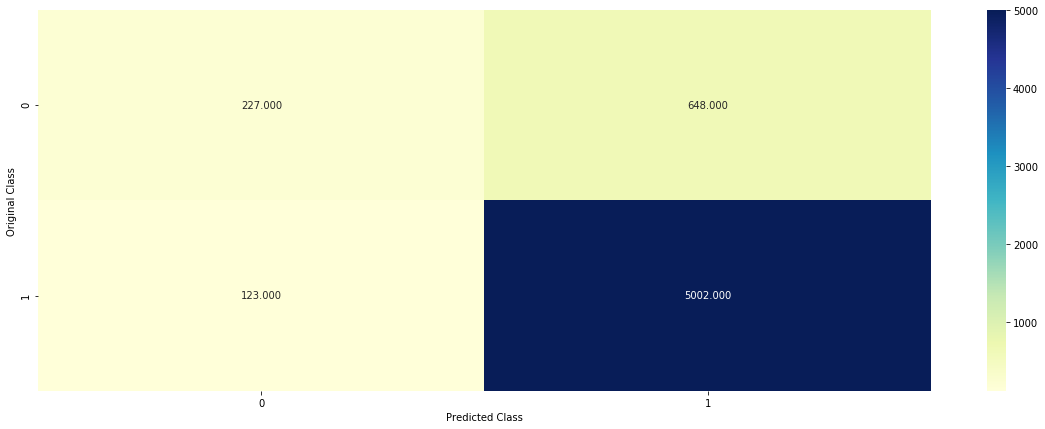

-------------------- Precision matrix (Columm Sum=1) --------------------


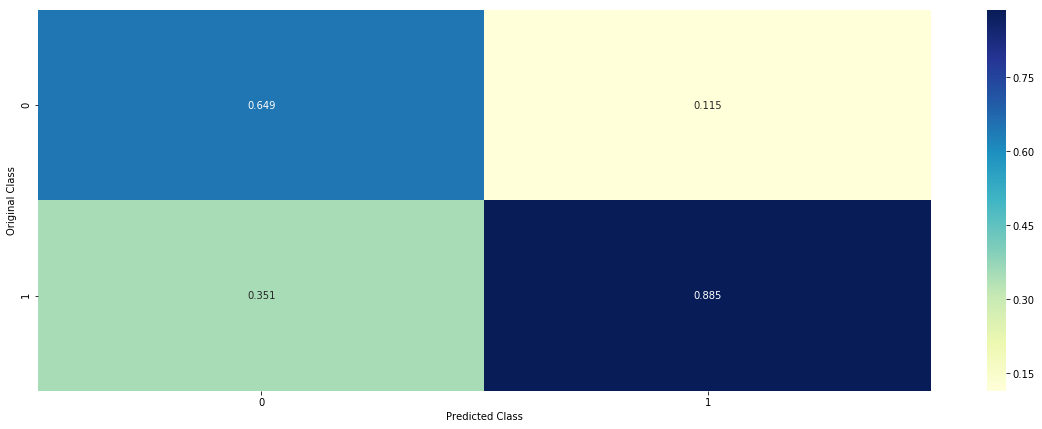

-------------------- Recall matrix (Row sum=1) --------------------


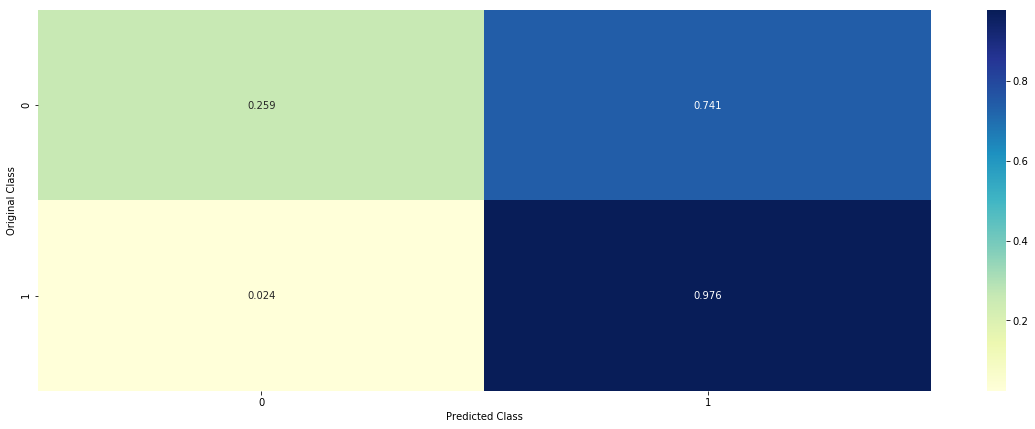

In [88]:
predict_y = sig_clf.predict(sent_vectors_test2)
plot_confusion_matrix(y_test2, predict_y)

# confusion matrix for train data

-------------------- Confusion matrix --------------------


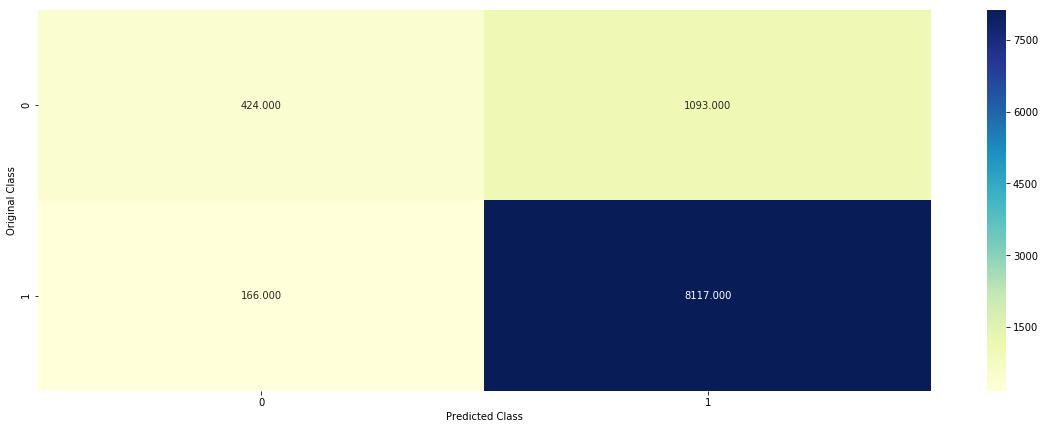

-------------------- Precision matrix (Columm Sum=1) --------------------


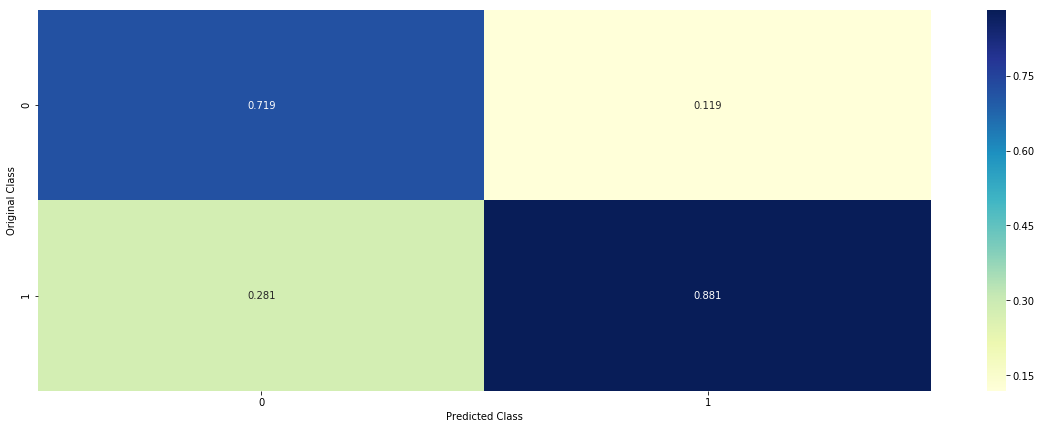

-------------------- Recall matrix (Row sum=1) --------------------


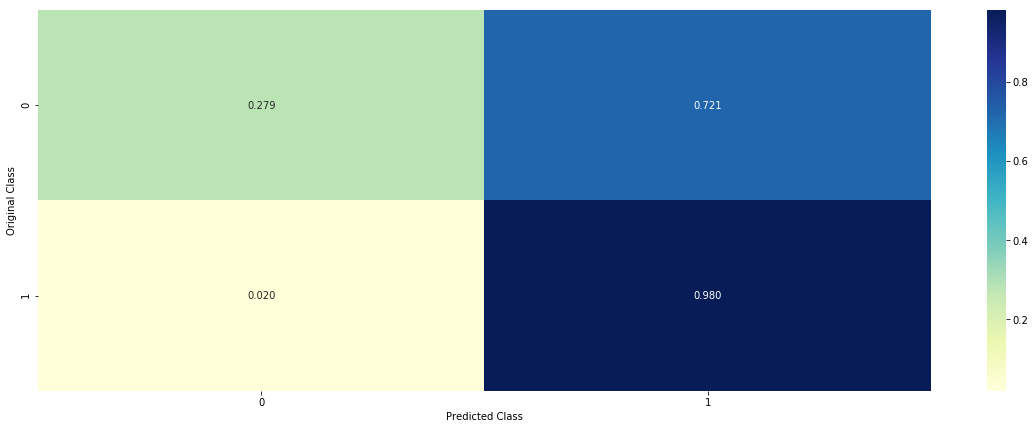

In [90]:
predict_y = sig_clf.predict(sent_vectors2)
plot_confusion_matrix(y_tr2, predict_y)

# ROC curve for train and test data of RBF Kernal svm for  AVG word2vec

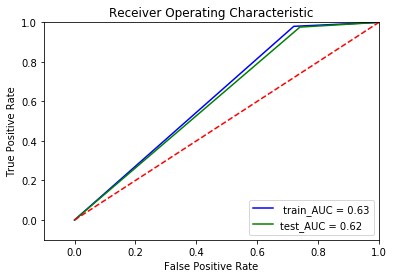

In [91]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

best_alpha = optimal_alpha
clf_bag= SVC(C=best_alpha)
clf_bag.fit(sent_vectors2, y_tr2)
sig_clf = CalibratedClassifierCV(clf_bag, method="sigmoid")
sig_clf.fit(sent_vectors2, y_tr2)

predict_y_train =  sig_clf.predict(sent_vectors2)
predict_y_test =sig_clf.predict(sent_vectors_test2)
y1= np.array(y_tr2)
y2=np.array(y_test2)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

for C = 1e-05
for C = 0.0001
for C = 0.001
for C = 0.01
for C = 0.1
for C = 1
for C = 10
for C = 100
for C = 1000
the auc score for each alpha value is :  [0.6631 0.6637 0.7155 0.7806 0.8041 0.8349 0.8389 0.8391 0.84  ]
the auc score for cv data for each alpha value is :  [0.6635 0.6634 0.6756 0.746  0.7734 0.8124 0.8197 0.8196 0.8214]

The optimal alpha is. 1000


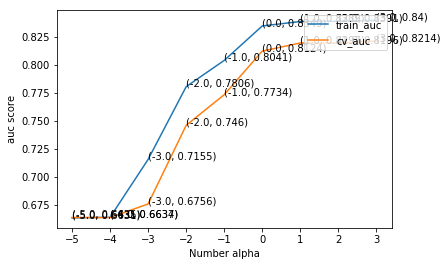

For values of best alpha =  1000 The train auc is: 0.860448579426327
For values of best alpha =  1000 The cross validation auc is: 82.87101535118299
For values of best alpha =  1000 The test  auc is: 84.17007944250872


In [92]:
# Please write all the code with proper documentation
# 
##
from sklearn.svm import SVC
alpha = [0.00001, 0.0001, 0.001,0.01, 0.1, 1, 10, 100,1000] ##various alpha values used for hyperparameter tuning
cv_scores_train=[]
cv_scores_cv=[]
for i in alpha:
    print("for C =", i)
    clf_word_tfidf= SVC(C=i)
    clf_word_tfidf.fit( tfidf_sent_vectors2, y_tr2)
    sig_clf = CalibratedClassifierCV(clf_word_tfidf, method="sigmoid")
    sig_clf.fit(tfidf_sent_vectors2, y_tr2)
    scores_train = cross_val_score(sig_clf, tfidf_sent_vectors2, y_tr2, cv=10, scoring='roc_auc')
    scores_cv = cross_val_score(sig_clf, tfidf_sent_vectors_cv2, y_cv2, cv=10, scoring='roc_auc')
    cv_scores_train.append(scores_train.mean())
    cv_scores_cv.append(scores_cv.mean())
print("the auc score for each alpha value is : ", np.round(cv_scores_train,4))
print("the auc score for cv data for each alpha value is : ", np.round(cv_scores_cv,4))
optimal_alpha = alpha[cv_scores_train.index(max(cv_scores_train))]  ### code for determining the best alpha
print('\nThe optimal alpha is.',optimal_alpha)
plt.plot(np.log10(alpha), cv_scores_train,label="train_auc")
plt.plot(np.log10(alpha), cv_scores_cv,label="cv_auc")


for xy in zip(np.log10(alpha), np.round(cv_scores_train,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
plt.xlabel('Number alpha')
plt.ylabel('auc score')
for xy in zip(np.log10(alpha), np.round(cv_scores_cv,4)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.grid()
#plt.xticks(alpha)
plt.xlabel('Number alpha')
plt.ylabel('auc score')
plt.legend(loc=1)
plt.show()

best_alpha = optimal_alpha
clf_word_tfidf= SVC(C=best_alpha)
clf_word_tfidf.fit(tfidf_sent_vectors2, y_tr2)
sig_clf = CalibratedClassifierCV(clf_word_tfidf, method="sigmoid")
sig_clf.fit(tfidf_sent_vectors2, y_tr2)

predict_y = sig_clf.predict_proba(tfidf_sent_vectors2)[:,1]
acc = roc_auc_score(y_tr2, predict_y)
print('For values of best alpha = ', best_alpha, "The train auc is:",acc) ### auc score for train data using best alpha valu
predict_y = sig_clf.predict_proba(tfidf_sent_vectors_cv2)[:,1]
acc = roc_auc_score( y_cv2, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The cross validation auc is:",acc) ### auc score for cv data using best alpha valu
predict_y = sig_clf.predict_proba(tfidf_sent_vectors_test2)[:,1]
acc = roc_auc_score( y_test2, predict_y) * 100
print('For values of best alpha = ', best_alpha, "The test  auc is:",acc) ### auc score for test data using best alpha valu


# construction of confusion matrix for test data

-------------------- Confusion matrix --------------------


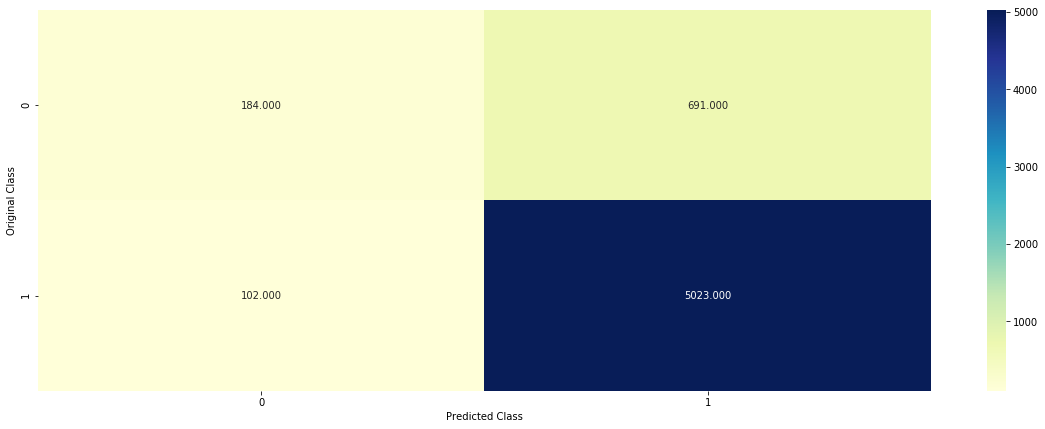

-------------------- Precision matrix (Columm Sum=1) --------------------


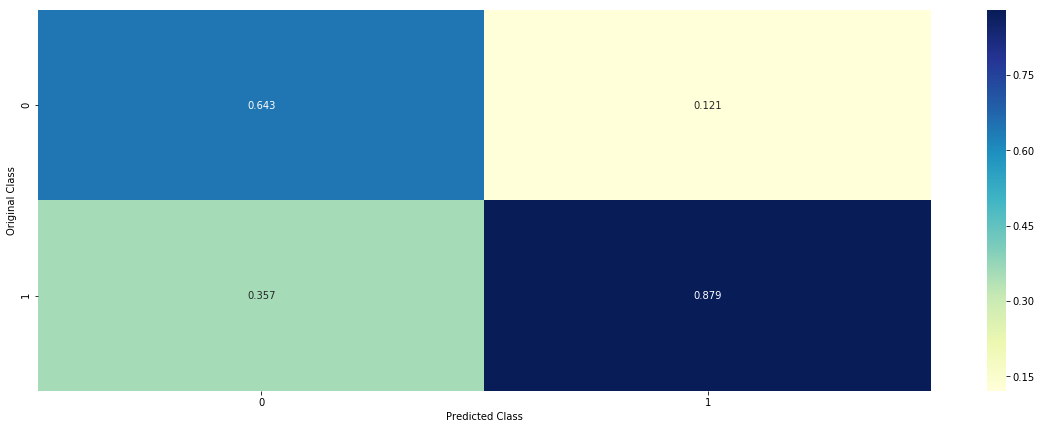

-------------------- Recall matrix (Row sum=1) --------------------


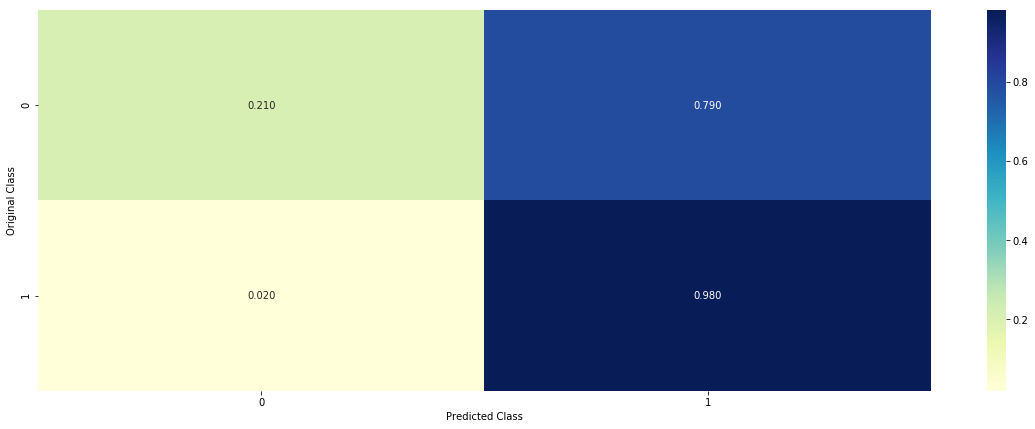

In [93]:
predict_y = sig_clf.predict(tfidf_sent_vectors_test2)
plot_confusion_matrix(y_test2, predict_y)

# confusion matrix for train data

-------------------- Confusion matrix --------------------


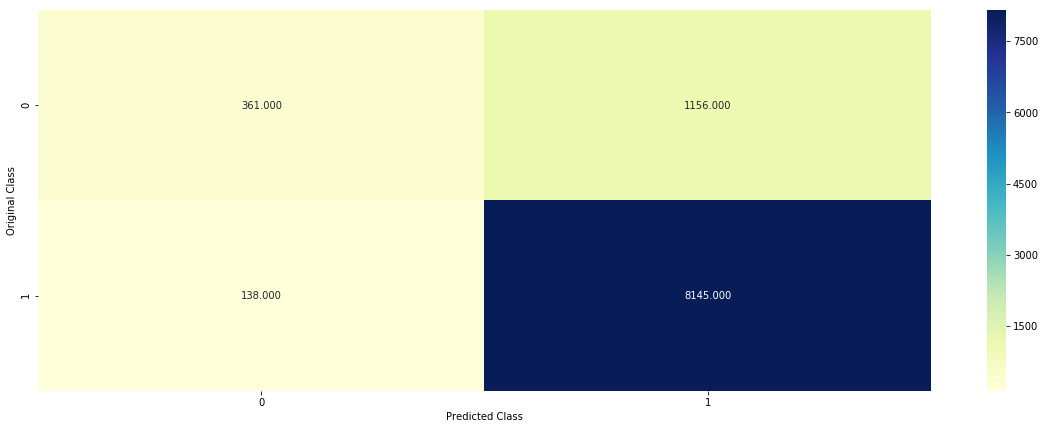

-------------------- Precision matrix (Columm Sum=1) --------------------


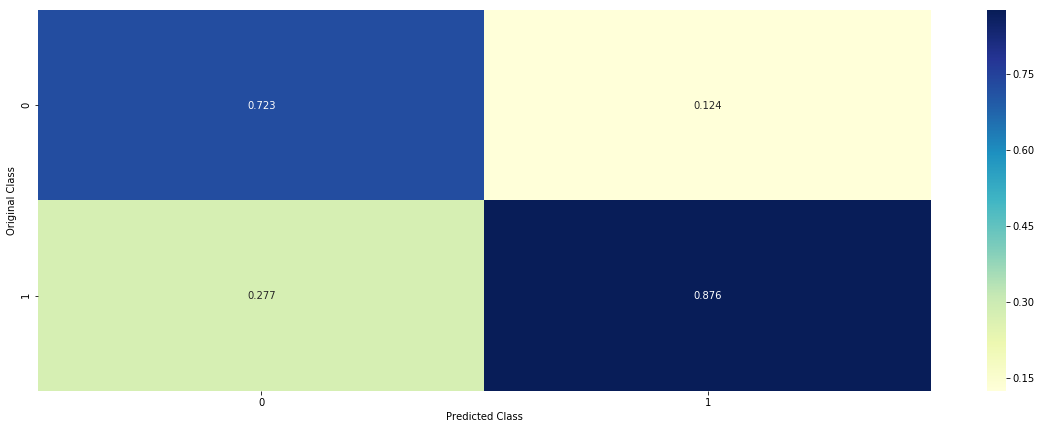

-------------------- Recall matrix (Row sum=1) --------------------


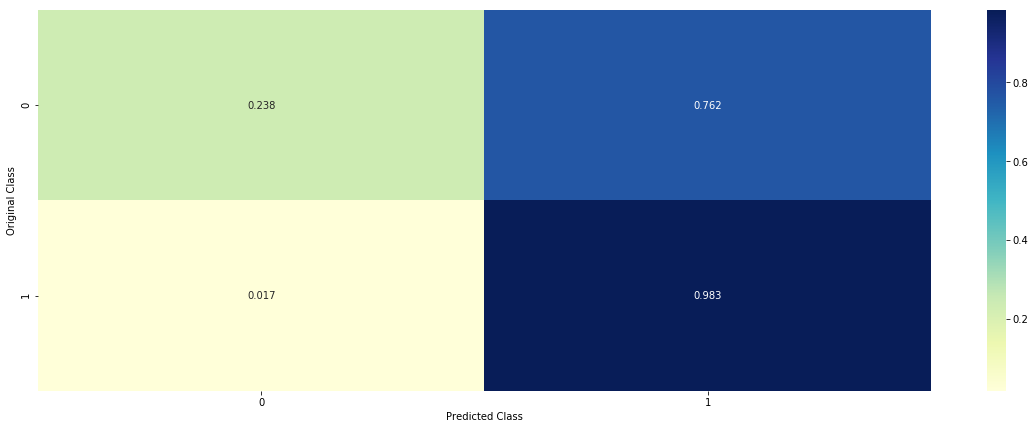

In [94]:
predict_y = sig_clf.predict(tfidf_sent_vectors2)
plot_confusion_matrix(y_tr2, predict_y)

# ROC curve for train and test data of RBF Kernal svm for TFIDF word2vec

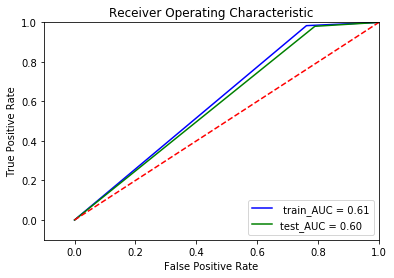

In [95]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

best_alpha = optimal_alpha
clf_bag= SVC(C=best_alpha)
clf_bag.fit(tfidf_sent_vectors2, y_tr2)
sig_clf = CalibratedClassifierCV(clf_bag, method="sigmoid")
sig_clf.fit(tfidf_sent_vectors2, y_tr2)

predict_y_train =  sig_clf.predict(tfidf_sent_vectors2)
predict_y_test =sig_clf.predict(tfidf_sent_vectors_test2)
y1= np.array(y_tr2)
y2=np.array(y_test2)
score=np.array(predict_y_train)
score2=np.array(predict_y_test)
fpr, tpr, thresholds = roc_curve(y1, score)
fpr1, tpr1, thresholds = roc_curve(y2, score2)
roc_auc = auc(fpr,tpr)
roc_auc2 = auc(fpr1,tpr1)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label=' train_AUC = %0.2f'% roc_auc)
plt.plot(fpr1, tpr1, 'g',
label='test_AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1])
plt.ylim([-0.1,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# [6] Conclusions

In [125]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC_train","AUC_CV","AUC_test"]
x.add_row(["BOW", "linear kernal",0.001 ,97.1324821623970, 93.72567170869293, 93.66839216038424])
x.add_row(["TF-IDF", "linear kernal", 0.001, 97.4476652325234,94.86056742815978,94.82219908865224])
x.add_row(["AVG-word 2vec", "linear kernal", 0.001,89.89172090679886, 89.7096836884608,89.71420252478673])

x.add_row([" TFIDF W2v", "linear kernal", 0.001,87.35814341139625, 87.11901215477673,86.85833666532707])

x.add_row(["BOW", "RBF kernal",10 ,93.25134491299101,87.84077907712094,89.20477212543554])

x.add_row(["TF-IDF", "RBF kernal", 100,98.09273721915837,92.28918508966406,92.94396655052265])
x.add_row(["AVG-word 2vec", "RBF kernal", 1000,87.24561612521966, 85.51017022802682,86.40093658536586])
x.add_row([" TFIDF W2v", "RBF kernal", 1000,86.0448579426327, 82.87101535118299,84.17007944250872])
print(x)
 
 


+---------------+---------------+----------------+-------------------+-------------------+-------------------+
|   Vectorizer  |     Model     | Hyperparameter |     AUC_train     |       AUC_CV      |      AUC_test     |
+---------------+---------------+----------------+-------------------+-------------------+-------------------+
|      BOW      | linear kernal |     0.001      |  97.132482162397  | 93.72567170869293 | 93.66839216038424 |
|     TF-IDF    | linear kernal |     0.001      |  97.4476652325234 | 94.86056742815978 | 94.82219908865224 |
| AVG-word 2vec | linear kernal |     0.001      | 89.89172090679887 |  89.7096836884608 | 89.71420252478673 |
|    TFIDF W2v  | linear kernal |     0.001      | 87.35814341139626 | 87.11901215477673 | 86.85833666532707 |
|      BOW      |   RBF kernal  |       10       | 93.25134491299102 | 87.84077907712094 | 89.20477212543554 |
|     TF-IDF    |   RBF kernal  |      100       | 98.09273721915837 | 92.28918508966406 | 92.94396655052265 |
|

In [ ]:
estimators,max-depth
50 ,500,99.94780197522708,86.01164129451989,86.30182199823363
50 ,500,99.9534116482917,88.68346390469432, 88.95166491690935
1000 , 500,99.9610670429983, 92.44837565550407, 92.3298167548008
500 ,500,99.94968201032289,91.38872297199215, 91.48985727501928